# Packages

In [30]:
import copy
import math
import os
import psycopg2
import sqlalchemy
import pandas as pd
import numpy as np
#from statsmodels import stats 
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from sqlalchemy import create_engine
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression as linreg
from fitter import Fitter
import random
import statsmodels.api as sm

# Constants and Utilities

In [31]:

conn_url = sqlalchemy.engine.URL.create(
    drivername='postgresql+psycopg2',
    username='jericho',
    password='Ilikesony1!',
    host='holocron.local',
    database='postgres'
)

eng = create_engine(conn_url)

n_bins = 6


#colors = ['maroon','indigo','navy','darkgreen']
#colors = ['royalblue','olivedrab','brown','rebeccapurple','darkgoldenrod']
#colors = ['#003f5c','#444e86','#955196','#dd5182','#ff6e54','#ffa600']
colors = ['blue', 'green', 'purple', 'red']


codes = {
'1_agg_H': 'Personal Care', 
'2_agg_H': 'Household Activities', 
'3_agg_H': 'Care for HH Members', 
'4_agg_H': 'Care for NH Members', 
'5_agg_H': 'Work', 
'6_agg_H': 'Education', 
'7_agg_H': 'Consumer Purchases', 
'8_agg_H': 'Prof. & Pers. Services',
'9_agg_H': 'Household Services', 
'10_agg_H': 'Govt Services & Civic', 
'11_agg_H': 'Eating & Drinking', 
'12_agg_H': 'Socializing & Leisure', 
'13_agg_H': 'Sports, Exrc & Rec', 
'14_agg_H': 'Religious & Spiritual', 
'15_agg_H': 'Volunteer Activities', 
'16_agg_H': 'Phone calls', 
'18_agg_H': 'Traveling', 
'ALL_TU_H': 'Any Activity', 
'CARE_TU_H': 'Care-Related Activities', 
'SOCIAL_TU_H': 'Any Social Activity'
}

alphas = ['1_agg_H', '2_agg_H', '3_agg_H', '4_agg_H', '5_agg_H', '6_agg_H', '7_agg_H', 
           '8_agg_H', '9_agg_H', '10_agg_H', '11_agg_H', '12_agg_H', '13_agg_H', '14_agg_H', 
           '15_agg_H', '16_agg_H', '18_agg_H', 'ALL_TU_H', 'SOCIAL_TU_H', 'CARE_TU_H']

s_filters = [ 0, 75,  0, 50,  0, 
              0, 75,  0,  0,  0, 
             75,  0,  0,  0,  0, 
              0, 75,  0,  0, 60]
s_filters_by_alpha = {alphas[i]:s_filters[i] for i in range(len(alphas))}

# Functions

### Pretty Display

In [32]:
def pretty_display(df):
    with pd.option_context('display.max_colwidth', None, 'display.max_rows', None): 
        display(df)

### Binplot

In [33]:
def binplot_dim(ax, x, y, nbins, **kwargs):
    df_xy = pd.DataFrame({'x':x,'y':y})
    df_xy = df_xy.sort_values('x')
    df_xy['xbin'] = pd.cut(df_xy['x'], nbins,)

    df_mean = df_xy.groupby('xbin').mean().reset_index()
    df_mean = df_mean[['xbin','y']]
    df_mean.columns = ['xbin','ybar']  

    df_xy = df_xy.merge(df_mean, how='left', on='xbin')
    df_xy['ysqerr'] = (df_xy['y']-df_xy['ybar'])**2
    df_xy['count'] = 1
    df_xy = df_xy.groupby('xbin').sum()
    df_xy = df_xy.reset_index()

    xbin = [[i.left, i.right] for i in df_xy['xbin'].tolist()]
    df_xy['xbin'] = xbin
    df_xy['x'] = [sum(i)/2 for i in xbin]
    df_xy['ystdev'] = (df_xy['ysqerr']/df_xy['count'])**0.5
    df_xy['ybar'] = df_xy['y']/df_xy['count']
    df_xy['ci_95'] = 1.96*(df_xy['ystdev'] / df_xy['count']**0.5)

    for i in xbin:
        ax.axvline(i[0], linestyle='--', c='grey', alpha=0.5)
    ax.axvline(xbin[-1][1], linestyle='--', c='grey', alpha=0.5)

    if 'linestyle' in kwargs.keys():
        style = kwargs['linestyle']
    else:
        style = '-'

    if 'alpha' in kwargs.keys():
        a = kwargs['alpha']
    else:
        a = 1

    ax.plot(df_xy['x'], df_xy['ybar'],c=kwargs['c'], linestyle=style, linewidth = int(kwargs['l']), marker=kwargs['m'], markersize=kwargs['lms'], label=kwargs['label'], alpha=a)
    #ax.scatter(df_xy['x'], df_xy['ybar'],c=kwargs['c'], s = kwargs['s']*1.5, marker = kwargs['m'])
    
    x_mid = df_xy['x'].tolist()
    ybar = df_xy['ybar'].tolist()
    ci95 = df_xy['ci_95'].tolist()
    
    for i in range(len(x_mid)):
        xt = x_mid[i]
        ymin = ybar[i]-ci95[i]
        ymax = ybar[i]+ci95[i]
        ax.vlines(x_mid[i], ymin=ymin, ymax=ymax, colors=kwargs['c'], linewidth = int(kwargs['l']), alpha=a)
        ax.scatter([xt,xt],[ymin,ymax], marker='_', c=kwargs['c'], s=kwargs['s'], alpha=a)
    return ax

### Boxplot Stats

In [34]:
def boxplot_stats(x):
    x = [i for i in x if not (np.isnan(i))]
    x_sort = sorted(x)
    x_25 = x_sort[int(len(x)/4)]
    x_50 = x_sort[int(len(x)/2)]
    x_75 = x_sort[int((len(x)/4)*3)]
    iqr_rang = (x_75-x_25)*1.5
    x_outliers = [i for i in x if i<(x_25-iqr_rang) or i>(x_75+iqr_rang)]
    return [max(min(x), x_25-iqr_rang), 
                x_25, 
                #sum(x)/len(x), # mean
                x_50, # median
                x_75, 
                min(max(x), x_75+iqr_rang), 
                x_outliers]


### Calc $f(g)$ and $t(g)$

In [35]:
def calc_f(df, alpha, ell, popbins, travel_correction = False, time='all', w=True):
    f_g = df.copy()
    f_g = f_g.replace(np.nan, 0)
    f_g['pop_bin'] = pd.cut(f_g['LOG_POP'], popbins)

    if time == 'wd':
        f_g = f_g[f_g['TUDIARYDAY'].isin([2.0, 3.0, 4.0, 5.0, 6.0])]
    elif time == 'we':
        f_g = f_g[f_g['TUDIARYDAY'].isin([1.0, 7.0])]

    if travel_correction:
        f_p = f_g[['pop_bin',alpha, 'LONGEST_TRIP_DUR']].copy()
        f_p = f_p[f_p['LONGEST_TRIP_DUR']<=ell]
        f_p = f_p[f_p['LONGEST_TRIP_DUR']>0]
        f_p = f_p.groupby('pop_bin').mean().reset_index()
        f_p = f_p[['pop_bin', alpha]]
        f_p.columns = ['pop_bin', 'v']

        f_g = f_g.merge(f_p, on='pop_bin',how='left')
        f_g['within_ell'] = f_g['LONGEST_TRIP_DUR'].apply(lambda x: 1 if x > 0 and x <=ell else 0)
        f_g['incoming_trav'] = f_g.apply(lambda x: x['v'] if np.isnan(x['LONGEST_TRIP_DUR']) else 0, axis=1) # no 0's in longest_trip_dur, just nans
        f_g[alpha] = f_g[alpha] * (f_g['within_ell']+f_g['incoming_trav']) # within_ell is 0 or 1, incoming_trav is v or 0

    else:
        # Only filter above ell
        f_g['filter'] = f_g['LONGEST_TRIP_DUR']<=ell

        # Filter 0 and above ell
        #f_g['filter'] = f_g['LONGEST_TRIP_DUR'].apply(lambda x: 1 if x > 0 and x <=ell else 0)
        
        f_g[alpha] = f_g[alpha] * f_g['filter'] 

    if w:
        f_g['weight'] = f_g['NEW_WEIGHT_y']
    else:
        f_g['weight'] = 1
    f_g = f_g[['TUCASEID','weight','GTCBSA',alpha]]
    f_g[alpha] = f_g[alpha]*f_g['weight']
    f_g = f_g.groupby('GTCBSA').sum().reset_index()
    f_g[alpha] = f_g[alpha]/f_g['weight']
    f_g = f_g[['GTCBSA',alpha]]
    f_g.columns = ['GTCBSA', f'f(g, alpha={alpha})']

    return f_g
    

def calc_t(df, alpha):
    df = df.copy()
    if '_H' in alpha:
        alpha = alpha[:-2]
    df = df[['GTCBSA','NEW_WEIGHT','LOG_POP',alpha]]
    df_bak = df[['GTCBSA','LOG_POP']].copy()
    df_bak = df_bak.drop_duplicates()
    df = df[['GTCBSA','NEW_WEIGHT',alpha]]
    df = df[df[alpha]>0]
    df[alpha] = df[alpha] * df['NEW_WEIGHT']
    df = df.groupby('GTCBSA').sum()
    df[alpha] = df[alpha] / df['NEW_WEIGHT']
    df = df.merge(df_bak, on='GTCBSA')
    return df

### Old KDE funcs

In [36]:
def kde_2d(x_dim, y_dim, x_fidelity, y_fidelity, bwidth=0.14,  x_range = False, y_range = False):
    xymatrix = np.column_stack((x_dim, y_dim))
    kde = KernelDensity(bandwidth=bwidth).fit(xymatrix)
    if x_range:
        x_range = [((min(x_range)*10)//1)/10, (((max(x_range)*10)//1)+1)/10]
    else:
        x_range = [((min(x_dim)*10)//1)/10, (((max(x_dim)*10)//1)+1)/10]
    if y_range:
        y_range = [((min(y_range)*10)//1)/10, (((max(y_range)*10)//1)+1)/10]
    else:
        y_range = [((min(y_dim)*10)//1)/10, (((max(y_dim)*10)//1)+1)/10]
    x_lin = np.linspace(x_range[0], x_range[1], num=x_fidelity)
    y_lin = np.linspace(y_range[0], y_range[1], num=y_fidelity)
    X, Y = np.meshgrid(x_lin,y_lin)
    XX = np.ravel(X)
    YY = np.ravel(Y)
    XY = np.column_stack((XX,YY))

    ZZ = kde.score_samples(XY)
    Z = ZZ.reshape(X.shape)
    return X, Y, Z


def normalize_whole_plot(Z):
    Z_out = (Z-Z.min()) / (Z.max()-Z.min())
    return Z_out


def normalize_cols(Z, type='minmax'):
    Z_df = pd.DataFrame(Z)
    if type == 'minmax':
        for col in Z_df.columns:
            max_val = Z_df[col].max()
            min_val = Z_df[col].min()
            Z_df[col] = (Z_df[col]-min_val) / (max_val-min_val)
    elif type == 'density':
        for col in Z_df.columns:
            Z_df[col] = [i/Z_df[col].sum() for i in Z_df[col]]
    return Z_df


def generate_KDE(df, y, x, b, f, p, y_range = False, x_range = False, y_fidelity=300, x_fidelity=300):
    # y = Y-axis of KDE plot
    # x = X-axis of KDE plot
    # b = KDE bandwidth
    # f = factor to amplify ridgeline by
    # p = power to take Z matrix to
    temp_df = copy.deepcopy(df)
    temp_df = temp_df[temp_df[y] > 0]
    temp_df = temp_df[[x,y]]
    x_dim = temp_df[x].tolist()
    y_dim = temp_df[y].tolist()
    X, Y, Z = kde_2d(x_dim, y_dim,  x_fidelity, y_fidelity, x_range=x_range, y_range=y_range, bwidth=b,)
    Z = normalize_whole_plot(Z)
    Z_df = normalize_cols(Z)
    # New order
    Z_edit = Z_df.copy().to_numpy()
    #Z_edit = Z_edit**p
    Z_edit[Z_edit == 1] = f
    #np.place(Z_edit, Z_edit == 1, f)

    Z_line = Z_df.to_numpy()
    #print(Z_line.max())
    Z_line[Z_line < 1] = 0
    
    # Original order
    #Z_edit = Z_df.replace(1,f).to_numpy()
    #Z_edit = Z_edit**p
    return X, Y, Z_edit, Z_line

### Various Helpers

In [37]:
def apply_threshold(df, thresh_name, keep_cols, thresh_col, thresh_value, thresh_array=''):
    df = df.copy()
    if thresh_array != '':
        idx = thresh_array.index(thresh_value)
        df['idx'] = df[thresh_col].apply(lambda x: thresh_array.index(x) if x==x else x)
        df['phi_D'] = df['idx'].apply(lambda x: 1 if x>=idx else 0)
    else:
        df['phi_D'] = df['idx'].apply(lambda x: 1 if x>=thresh_value else 0)
    df = df[keep_cols + [thresh_name]]
    return df


def weighted_agg(df, agg_by, weight, data, label):
    df = df.copy()
    df[label] = df[weight]*df[data]
    df = df.groupby(agg_by).sum().reset_index()
    df[label] = df[label] / df[weight]
    return df[[agg_by, label]]


def apply_sampling_threshold(df, counter, threshold):
    # cutoff is > threshold
    df = df.copy()
    array = df[counter].tolist()
    counted = {}
    for i in array:
        if i in counted:
            counted[i] += 1
        else:
            counted[i] = 1
    df['c'] = df[counter].apply(lambda x: counted[x])
    #display(df)
    df = df[df['c']>threshold]
    df = df.drop('c', axis=1)
    return df


def roll_matrix(m, s,  axis=None):
    m = m.copy()
    ms = []
    for i in range(s):
        mt = np.roll(m,i+1,  axis=axis)
        m_t = np.roll(m, -(i+i), axis=axis)
        ms.append(mt)
        ms.append(m_t)
    for i in ms:
        m += i
    m[m>1]=1
    m[m<1]=0
    return m


def dist_aggregator(array):
    dist = {'None':0,
            '1 up to 5':0,
            '6 up to 10':0,
            '11 up to 20':0,
            'More than 20':0}
    for i in array:
        if i == 0:
            dist['None'] += 1
        elif i < 6:
            dist['1 up to 5'] += 1
        elif i < 11:
            dist['6 up to 10'] += 1
        elif i < 21:
            dist['11 up to 20'] += 1
        else:
            dist['More than 20'] += 1
    for k,v in dist.items():
        dist[k] = v / len(array)
    return pd.DataFrame({'bin':dist.keys(), 'pr':dist.values()})


def dist_error_calc(df1, df2, join_on, pr1, pr2):
    df1 = df1[[join_on, pr1]].copy()
    df2 = df2[[join_on, pr2]].copy()
    dfc = df1.merge(df2, on=join_on)
    dfc['sq_err'] = (dfc[pr1] - dfc[pr2])**2
    return dfc['sq_err'].sum()

# Data

In [38]:
# Basic Datasets
df_resp_data = pd.read_sql_query('SELECT * FROM postgres.cdsdata."atus_resp_t.csv"', con=eng)
df_resp_data = df_resp_data[df_resp_data.columns.tolist()[2:]]
df_tus = pd.read_sql_query('SELECT * FROM postgres.cdsdata."mkl1_ATUS_data_pew_classes"', con=eng)
df_pew = pd.read_sql_query('SELECT * FROM postgres.cdsdata."mkl1_PEW_phi_w"', con=eng)
#df_parent = pd.read_csv('ATUS_parents.csv')
df_tus_trunc = df_tus[df_tus.GTCBSA.isin(df_pew.GTCBSA.unique().tolist())].copy()
df_pew_trunc = df_pew[df_pew.GTCBSA.isin(df_tus_trunc.GTCBSA.unique().tolist())].copy()
df_tus_cbsa = df_tus_trunc[['GTCBSA','LOG_POP']].drop_duplicates()
df_tus_trunc['care_nh_hh'] = df_tus_trunc['3_agg_H']+df_tus_trunc['4_agg_H']
df_tus_trunc['CARE_TU_H'] = df_tus_trunc['care_nh_hh'].apply(lambda x: 1 if x >=1 else 0)
df_tus_trunc_OG = df_tus_trunc.copy()
df_calls = pd.read_csv('ATUS_call_counts.csv')
df_tus_trunc_copy = df_tus_trunc_OG.copy()
df_tus_trunc_copy['care_nh_hh'] = df_tus_trunc_copy['3_agg_H']+df_tus_trunc_copy['4_agg_H']
df_tus_trunc_copy['CARE_TU_H'] = df_tus_trunc_copy['care_nh_hh'].apply(lambda x: 1 if x >=1 else 0)


# Time Use MAIN
df_t = df_resp_data.copy()
df_t = df_t[df_t['GTCBSA'].isin(df_tus_cbsa['GTCBSA'])]
df_t = df_t[['GTCBSA','LOG_POP','NEW_WEIGHT']+[i[:-2] for i in alphas]]


# Time Use SPECIFIC
df_cbsa_t = calc_t(df_t, 'ALL_TU_H')
df_cbsa_t


## DS Distribution
order = {'1 up to 5':1, '11 up to 20':3, '6 up to 10':2, 'More than 20':4, 'None':0}
df_dist = df_pew[['q7_family_members','weight']].copy()
df_dist.columns = ['bin','weight']
df_dist['count'] = 1
df_dist = df_dist.groupby('bin').sum().reset_index()
df_dist['order'] = df_dist['bin'].apply(lambda x: order[x])
df_dist = df_dist.sort_values('order')
df_dist = df_dist.drop('order',axis=1)
df_dist['pr_phi_DS'] = df_dist['weight'] / df_dist['weight'].sum()
df_dist['pr_phi_no_w'] = df_dist['count'] / df_dist['count'].sum()


# TUS Sampling Dist
df_sampling = df_tus_trunc[['GTCBSA','LOG_POP']].copy()
df_cbsa = df_sampling.drop_duplicates().copy()
df_sampling['count'] = 1
df_sampling = df_sampling.groupby('GTCBSA').sum()
df_sampling = df_sampling.reset_index()
df_sampling = df_sampling[['GTCBSA','count']]
df_sampling = df_cbsa.merge(df_sampling, on='GTCBSA')
df_sampling = df_sampling.sort_values('LOG_POP')
df_sampling['POP'] = df_sampling['LOG_POP'].apply(lambda x: 10**x)
df_sampling['sampling_rate'] = df_sampling['count'] #/ df_sampling['POP']
df_sampling = df_sampling[['GTCBSA','sampling_rate']]


### Raw counts by Alpha

In [39]:
print(len(df_pew_trunc))
print(len(df_tus_trunc))

1706
30454


In [40]:
str_a, cnt_a = [],[]
for a in alphas:
    str_a.append(codes[a])
    cnt_a.append(df_tus_trunc[a].sum())

raw_counts=pd.DataFrame({'alpha':alphas, 'alpha desc':str_a, 'raw count':cnt_a})
raw_counts

alpha               alpha desc  raw count
0       1_agg_H            Personal Care       42.0
1       2_agg_H     Household Activities     1735.0
2       3_agg_H      Care for HH Members      595.0
3       4_agg_H      Care for NH Members     1766.0
4       5_agg_H                     Work      229.0
5       6_agg_H                Education       37.0
6       7_agg_H       Consumer Purchases     1085.0
7       8_agg_H   Prof. & Pers. Services      160.0
8       9_agg_H       Household Services       41.0
9      10_agg_H    Govt Services & Civic       14.0
10     11_agg_H        Eating & Drinking     3753.0
11     12_agg_H    Socializing & Leisure     5110.0
12     13_agg_H       Sports, Exrc & Rec      461.0
13     14_agg_H    Religious & Spiritual      381.0
14     15_agg_H     Volunteer Activities      117.0
15     16_agg_H              Phone calls       98.0
16     18_agg_H                Traveling     2831.0
17     ALL_TU_H             Any Activity     7402.0
18  SOCIAL_TU_H      Any Social Activity     6307.0
19    CARE_TU_H  Care-Related Activities     2262.0

# DS calculation

In [41]:
def get_discrete_probabilities(n, p):
    pr_dict = {}
    prior = 0
    for i in range(31):
        pr = stats.nbinom.cdf(i, n, p, loc=0)
        pr_dict[i] = pr - prior
        prior = pr
    return pr_dict

def get_bin_probabilities(pr_dict, bin_dict):
    bin_prs = {}
    for bin, phis in bin_dict.items():
        phi_sum = sum([pr_dict[i] for i in phis])
        bin_prs[bin] = {phi: pr_dict[phi]/phi_sum for phi in phis}
    return bin_prs

def bin_cdf(bin_dict):
    out_dict = {}
    for bin, bin_prs in bin_dict.items():
        out_dict[bin] = {}
        cumu = 0
        for n, pr in sorted(bin_prs.items()):
            out_dict[bin][n] = (cumu, cumu+pr)
            cumu += pr
    return out_dict


In [42]:
def apply_threshold(df, thresh_name, keep_cols, thresh_col, thresh_value, thresh_array=''):
    df = df.copy()
    if thresh_array != '':
        idx = thresh_array.index(thresh_value)
        df['idx'] = df[thresh_col].apply(lambda x: thresh_array.index(x) if x==x else x)
        df['phi_D'] = df['idx'].apply(lambda x: 1 if x>=idx else 0)
    else:
        df['phi_D'] = df['idx'].apply(lambda x: 1 if x>=thresh_value else 0)
    df = df[keep_cols + [thresh_name]]
    return df


def apply_ds_threshold(df, thresh_name, keep_cols, thresh_col, thresh_value, pr_bin_cdf, pr_cumu_bins, sample=False): 
    # RANDOM VERSION
    f_classes = ['None', '1 up to 5', '6 up to 10', '11 up to 20', 'More than 20']
    tdict = {0:'None',1:'1 up to 5',2:'1 up to 5',3:'1 up to 5',4:'1 up to 5',5:'1 up to 5',6:'6 up to 10',
        7:'6 up to 10',8:'6 up to 10',9:'6 up to 10',10:'6 up to 10',11:'11 up to 20',12:'11 up to 20',
        13:'11 up to 20',14:'11 up to 20',15:'11 up to 20',16:'11 up to 20',17:'11 up to 20',18:'11 up to 20',
        19:'11 up to 20',20:'11 up to 20',21:'More than 20'}
    df = df.copy()
    thresh_string = tdict[thresh_value]
    thresh_idx = f_classes.index(thresh_string)
    array = df[thresh_col].tolist()
    thresh_array = []
    for i in array:
        test_value = f_classes.index(i)
        #print(i, test_value, thresh_idx)
        if test_value > thresh_idx:
            thresh_array.append(1)
        elif test_value < thresh_idx:
            thresh_array.append(0)
        else:
            if sample:
                r = random.random()
                if r > pr_bin_cdf[thresh_string][thresh_value][0]:
                    thresh_array.append(1)
                else:
                    thresh_array.append(0)
            else:
                thresh_array.append(pr_cumu_bins[thresh_string][thresh_value])
    df['threshold_met'] = thresh_array
    df[thresh_name] = df['threshold_met'] * df['Family Available']
    df = df[keep_cols + [thresh_name]]
    return df


In [43]:
bin_dict = {
    'None': [0],
    '1 up to 5': [i for i in range(1,6)],
    '6 up to 10': [i for i in range(6,11)],
    '11 up to 20': [i for i in range(11,21)],
    'More than 20': [i for i in range(21,31)],
}


pr_dict = get_discrete_probabilities(0.55, 0.055)
pr_bins = get_bin_probabilities(pr_dict, bin_dict)
pr_bin_cdf = bin_cdf(pr_bins)

pr_cumu_bins = {}
for fc,ds_bin in pr_bin_cdf.items():
    pr_cumu_bins[fc] = {}
    for ds, pr in ds_bin.items():
        print(fc, ds, pr)
        pr_cumu_bins[fc][ds] = 1-pr[0]

None 0 (0, 1.0)
1 up to 5 1 (0, 0.3088017683789736)
1 up to 5 2 (0.3088017683789736, 0.5349604634955243)
1 up to 5 3 (0.5349604634955243, 0.716622435347894)
1 up to 5 4 (0.716622435347894, 0.8689800603658278)
1 up to 5 5 (0.8689800603658278, 1.0)
6 up to 10 6 (0, 0.24877034627508013)
6 up to 10 7 (0.24877034627508013, 0.4687455249688188)
6 up to 10 8 (0.4687455249688188, 0.6649290132419632)
6 up to 10 9 (0.6649290132419632, 0.8410527398391792)
6 up to 10 10 (0.8410527398391792, 0.9999999999999999)
11 up to 20 11 (0, 0.14443453079945812)
11 up to 20 12 (0.14443453079945812, 0.2758067637197401)
11 up to 20 13 (0.2758067637197401, 0.3956561359794575)
11 up to 20 14 (0.3956561359794575, 0.5052733680825017)
11 up to 20 15 (0.5052733680825017, 0.6057540038897575)
11 up to 20 16 (0.6057540038897575, 0.698037617829049)
11 up to 20 17 (0.698037617829049, 0.7829371855412272)
11 up to 20 18 (0.7829371855412272, 0.8611615247420358)
11 up to 20 19 (0.8611615247420358, 0.9333327410633703)
11 up to 2

# KDE w/ DS dist & Mirroring

In [44]:

def mirror_2d(x,y, axis=0): #axis = 0 for X, axis=1 for Y
    target_var = x if axis==0 else y
    unaffected_var = y if axis==0 else x
    range_max = min(target_var)
    target_var = [(i * -1) for i in target_var]
    range_min = max(target_var)
    range = range_max-range_min
    target_var = [i+range for i in target_var]

    if axis == 0:
        return target_var, unaffected_var
    else: return unaffected_var, target_var

def mirror_2d_on0(x,y, axis=0): #axis = 0 for X, axis=1 for Y
    target_var = x if axis==0 else y
    unaffected_var = y if axis==0 else x
    range_max = min(target_var)
    target_var = [(i * -1) for i in target_var]
    if axis == 0:
        return target_var, unaffected_var
    else: return unaffected_var, target_var

def extract_trendline(x,y,z):
    xs, ys = [], []
    for i in range(len(z)):
        for j in range(len(z[i])):
            if z[i][j] == 1.0:
                xs.append(x[i][j])
                ys.append(y[i][j])
    return xs, ys


def normalize_cols(Z, type='minmax'):
    Z_df = pd.DataFrame(Z)
    if type == 'minmax':
        for col in Z_df.columns:
            max_val = Z_df[col].max()
            min_val = Z_df[col].min()
            Z_df[col] = (Z_df[col]-min_val) / (max_val-min_val)
    elif type == 'density':
        for col in Z_df.columns:
            Z_df[col] = [i/Z_df[col].sum() for i in Z_df[col]]
            zmax = Z_df[col].max()
            Z_df[col] = [i/zmax if i>0 else 0 for i in Z_df[col]]
    return Z_df

## (depr) Prior version

In [45]:
# df_tus_trunc = df_tus_trunc_OG.merge(df_calls, on='TUCASEID', how='left').copy()
# #df_tus_trunc = df_tus_trunc[df_tus_trunc['TUATTMPTNO']>30]
# df_tus_f = calc_f(df_tus_trunc, 'ALL_TU_H', 60, 6)


# f_classes = ['None', '1 up to 5', '6 up to 10', '11 up to 20', 'More than 20']

# y_fid = 2000
# x_fid = 200
# roll = 1
# bandwidth = 0.25
# kde_exponent = 2
# plt.rcParams['font.size'] = 14

# trend_line_val = 0.5

# xyzs = []

# for f in f_classes[2:3]:
#     for t in [4]:

#         print('Sampling Threshold:', t,'(less than',t+1,'removed)')
#         print('Family-members Threshold:',f)
#         temp_df = apply_sampling_threshold(df_pew_trunc, 'GTCBSA', t)
#         temp_df = apply_threshold(temp_df, 'phi_D', ['GTCBSA','weight'], 'q7_family_members', f, thresh_array = f_classes)
#         df_pew_phi_d = weighted_agg(temp_df, 'GTCBSA', 'weight', 'phi_D', 'phi_D')
#         df_combined = df_tus_cbsa.merge(df_tus_f, on='GTCBSA', how='inner')
#         df_combined = df_combined.merge(df_pew_phi_d, on='GTCBSA', how='inner')
#         df_combined = df_combined[df_combined['phi_D']>0]
#         df_combined['f/phi'] = df_combined['f(g, alpha=ALL_TU_H)'] / df_combined['phi_D']

#         print(len(df_combined))

#         #fig, axes = plt.subplots(2,3,figsize=(8,5), dpi=300, facecolor='white', gridspec_kw={'width_ratios': [10, 10, 1]}, constrained_layout=True)

#         fig = plt.figure(figsize=(10,5), dpi=300, facecolor='white',)
#         gs = gridspec.GridSpec(2,3, width_ratios=[10,10,1], height_ratios=[1,1])

#         ax1 = fig.add_subplot(gs[:1, :1])
#         ax2 = fig.add_subplot(gs[:1, 1:2])
#         ax3 = fig.add_subplot(gs[1:, :1])
#         ax4 = fig.add_subplot(gs[1:, 1:2])
#         ax5 = fig.add_subplot(gs[:, -1:])

#         X, Y, Z, Z_line = generate_KDE(df_combined, 'f(g, alpha=ALL_TU_H)', 'LOG_POP', bandwidth, trend_line_val, kde_exponent, x_range=[5.25, 7.5], y_fidelity=y_fid, x_fidelity=x_fid)
#         xyzs.append([X,Y,Z_line])
#         Z_line = roll_matrix(Z_line, roll, axis=(0))
#         Z = np.maximum(Z, Z_line)
#         Z[Z==1] = trend_line_val
#         ax1.pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')
#         #axes[0,0].pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')
#         #axes[0].pcolormesh(X,Y,Z_line)


#         X, Y, Z, Z_line = generate_KDE(df_combined, 'phi_D', 'LOG_POP', bandwidth, trend_line_val, kde_exponent, x_range=[5.25, 7.5], y_fidelity=y_fid, x_fidelity=x_fid)
#         xyzs.append([X,Y,Z_line])
#         Z_line = roll_matrix(Z_line, roll, axis=(0))
#         Z = np.maximum(Z, Z_line)
#         Z[Z==1] = trend_line_val
#         ax2.pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')
#         #axes[0,1].pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')


#         #df_combined = df_combined[df_combined['f/phi']<2]

#         X, Y, Z, Z_line = generate_KDE(df_combined, 'f/phi', 'LOG_POP', bandwidth, trend_line_val, kde_exponent, x_range=[5.25, 7.5], y_range=[0,1.1], y_fidelity=y_fid, x_fidelity=x_fid)
#         xyzs.append([X,Y,Z_line])
#         Z_line = roll_matrix(Z_line, roll, axis=(0))
#         Z = np.maximum(Z, Z_line)
#         Z[Z==1] = trend_line_val
#         ax3.pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')
#         #axes[1,0].pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')

#         temp_df = df_cbsa_t.copy()
#         temp_df['ALL_TU'] = temp_df['ALL_TU']/100
#         X, Y, Z, Z_line = generate_KDE(temp_df, 'ALL_TU', 'LOG_POP', 1, trend_line_val, kde_exponent, x_range=[5.25, 7.5], y_range=[3, 3.5], y_fidelity=y_fid, x_fidelity=x_fid)
#         Y = Y*100
#         xyzs.append([X,Y,Z_line])
#         Z_line = roll_matrix(Z_line, roll, axis=(0))
#         Z = np.maximum(Z, Z_line)
#         Z[Z==1] = trend_line_val
#         ax4.pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')
#         #axes[1,1].pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')


#         cmap = mpl.cm.coolwarm
#         norm = mpl.colors.Normalize(vmin=Z.min(), vmax=Z.max())

#         cb1 = mpl.colorbar.ColorbarBase(ax5, cmap=cmap,
#                                         norm=norm,
#                                         orientation='vertical')
#         # cb1 = mpl.colorbar.ColorbarBase(axes[0,2], cmap=cmap,
#         #                         norm=norm,
#         #                         orientation='vertical')
#         cb1.set_label('Norm. PDF:\n$(Pr(var)/Pr(var*))^2$')




#         # cmap = mpl.cm.coolwarm
#         # norm = mpl.colors.Normalize(vmin=Z.min(), vmax=Z.max())

#         # cb1 = mpl.colorbar.ColorbarBase(axes[4], cmap=cmap,
#         #                                 norm=norm,
#         #                                 orientation='vertical')
#         # #cb1.set_label('Norm. PDF of $\phi_{DS}(g, n_f)$:\n$Pr(\phi_{DS})/Pr(\phi_{DS}*)$')
#         # cb1.set_label('Norm. PDF:\n$(Pr(var)/Pr(var*))^2$')


#         # axes[0,0].set_ylabel('Family Interaction:\n$f(g)$')
#         # axes[0,1].set_ylabel('Family Availability:\n$\phi_{DS}(g, n_f)$')
#         # axes[1,0].set_ylabel('Effective Propensity:\n$\lambda(g, n_f)$')
#         # axes[1,1].set_ylabel('Interaction Time:\n$t(g)$')
#         # axes[2,0].set_xlabel('Log of Population: log(p)')

#         ax1.set_ylabel('Family Interaction:\n$f(g)$')
#         ax2.set_ylabel('Family Availability:\n$\phi_{DS}(g, n_f)$')
#         ax3.set_ylabel('Effective Propensity:\n$\lambda(g, n_f)$')
#         ax4.set_ylabel('Interaction Duration:\n$t(g)$')
#         ax3.set_xlabel('Log of Population: $p(g)$')
#         ax4.set_xlabel('Log of Population: $p(g)$')
        
#         ax1.xaxis.set_minor_locator(AutoMinorLocator())
#         ax2.xaxis.set_minor_locator(AutoMinorLocator())
#         ax3.xaxis.set_minor_locator(AutoMinorLocator())
#         ax4.xaxis.set_minor_locator(AutoMinorLocator())

#         ax1.yaxis.set_minor_locator(AutoMinorLocator())
#         ax2.yaxis.set_minor_locator(AutoMinorLocator())
#         ax3.yaxis.set_minor_locator(AutoMinorLocator())
#         ax4.yaxis.set_minor_locator(AutoMinorLocator())
#         ax5.yaxis.set_minor_locator(AutoMinorLocator())

#         # plt.subplots_adjust(left=0.1,
#         #             bottom=0.1,
#         #             right=0.9,
#         #             top=0.9,
#         #             wspace=0.4,
#         #             hspace=0.4)
#         #plt.tight_layout(pad=0.2)
#         #plt.show()
        
#         plt.tight_layout()
#         plt.show()
#         # filename = f.replace(' ','_') + '_n=>'+str(t+1)+'.png'
#         # plt.savefig('/Users/jericho/Documents/csi/csi-research/Notebooks/MKL_2_notebooks/images/KDE_'+filename)

## 4-Panel KDE

In [46]:
print(df_t.columns, alphas)

Index(['GTCBSA', 'LOG_POP', 'NEW_WEIGHT', '1_agg', '2_agg', '3_agg', '4_agg',
       '5_agg', '6_agg', '7_agg', '8_agg', '9_agg', '10_agg', '11_agg',
       '12_agg', '13_agg', '14_agg', '15_agg', '16_agg', '18_agg', 'ALL_TU',
       'SOCIAL_TU', 'CARE_TU'],
      dtype='object') ['1_agg_H', '2_agg_H', '3_agg_H', '4_agg_H', '5_agg_H', '6_agg_H', '7_agg_H', '8_agg_H', '9_agg_H', '10_agg_H', '11_agg_H', '12_agg_H', '13_agg_H', '14_agg_H', '15_agg_H', '16_agg_H', '18_agg_H', 'ALL_TU_H', 'SOCIAL_TU_H', 'CARE_TU_H']


In [47]:
df_cbsa_t = calc_t(df_t, 'CARE_TU_H')
df_cbsa_t

GTCBSA  NEW_WEIGHT     CARE_TU  LOG_POP
0     10420     10845.0  155.914246     5.85
1     10580     27005.0  145.934086     5.94
2     10740     43819.0  250.524658     5.96
3     10900     39719.0   70.477479     5.92
4     11100      9154.0   10.000000     5.42
..      ...         ...         ...      ...
204   49180     72089.0  140.910056     5.82
205   49340     59402.0   58.839332     5.97
206   49620     21502.0   97.300437     5.65
207   49660     46181.0   73.599684     5.73
208   49740     15534.0   62.902343     5.32

[209 rows x 4 columns]

In [48]:
df_tus_f = calc_f(df_tus_trunc, 'ALL_TU_H', 60, 6)
temp_df = apply_sampling_threshold(df_pew_trunc, 'GTCBSA', 1)
temp_df = apply_ds_threshold(temp_df, 'phi_D', ['GTCBSA','weight'], 'q7_family_members', 3, pr_bin_cdf, pr_cumu_bins)
temp_df

GTCBSA    weight    phi_D
0     14860.0  3.547619  0.00000
1     13820.0  2.250000  0.46504
2     13820.0  2.523810  1.00000
3     13820.0  3.333333  1.00000
4     42660.0  5.119048  0.00000
...       ...       ...      ...
2244  35620.0  1.018868  0.46504
2245  35620.0  1.687500  1.00000
2246  35620.0  3.187500  0.00000
2247  14460.0  2.245283  0.46504
2248  29620.0  1.754717  1.00000

[1665 rows x 3 columns]

In [49]:
def get_kde_data(alpha, pew_sampling_threshold, pew_ds_threshold, tus_sampling_threshold, w=True):
    df_tus_f = calc_f(df_tus_trunc, alpha, 60, 6, w=w)
    temp_df = apply_sampling_threshold(df_pew_trunc, 'GTCBSA', pew_sampling_threshold)
    temp_df = apply_ds_threshold(temp_df, 'phi_D', ['GTCBSA','weight'], 'q7_family_members', pew_ds_threshold, pr_bin_cdf, pr_cumu_bins)
    df_pew_phi_d = weighted_agg(temp_df, 'GTCBSA', 'weight', 'phi_D', 'phi_D')
    df_combined = df_tus_cbsa.merge(df_tus_f, on='GTCBSA', how='inner')
    df_combined = df_combined.merge(df_pew_phi_d, on='GTCBSA', how='inner')
    df_combined['f/phi'] = df_combined[f'f(g, alpha={alpha})'] / df_combined['phi_D']

    df_combined['f/phi'] = df_combined['f/phi'].replace([np.inf, -np.inf], np.nan)
    df_combined['f/phi'] = df_combined['f/phi'].replace(np.nan, 0)

    df_combined = df_combined.merge(df_sampling, on='GTCBSA',how='left')
    df_combined = df_combined[df_combined['sampling_rate']>=tus_sampling_threshold]
    df_time = calc_t(df_t, alpha)
    df_time[alpha[:-2]] = df_time[alpha[:-2]]/60
    return df_combined, df_time


def get_kde_matrices(df, x_var, y_var, x_fid, y_fid, pad, forced_y_max = False):
    min_f = df[y_var].min()
    if forced_y_max:
        max_f = forced_y_max
    else:
        max_f = df[y_var].max()
    f_range = abs(max_f-min_f)
    min_f -= f_range / (1/pad)
    max_f += f_range / (1/pad)
    min_p = df[x_var].min()
    max_p = df[x_var].max()
    p_range = abs(max_p-min_p)
    min_p -= p_range / (1/pad)
    max_p += p_range / (1/pad)
    X, Y = np.mgrid[min_p:max_p:x_fid, min_f:max_f:y_fid]
    positions = np.vstack([X.ravel(), Y.ravel()])

    x_array = df[x_var].tolist()
    y_array = df[y_var].tolist()
    return X, Y, x_array, y_array, positions


def generate_KDE_adj(bw, X, Y, x_array, y_array, positions, boundary=False, normalize=False, contrast_trend=False):
    y_array
    values = np.vstack([x_array, y_array])
    kernel = stats.gaussian_kde(values, bw_method=bw)
    Z = np.reshape(kernel(positions).T, X.shape)

    if boundary:
        x2_array, y2_array = mirror_2d_on0(x_array,y_array, axis=1)
        values2 = np.vstack([x2_array, y2_array])
        kernel = stats.gaussian_kde(values2, bw_method=bw)
        Z2 = np.reshape(kernel(positions).T, X.shape)
        Z = Z+Z2

    if normalize:
        Z_df = normalize_cols(Z.T)#, type='density')
        Z = Z_df.to_numpy()
        Z = Z.T

    trend = extract_trendline(X,Y,Z)

    if normalize & contrast_trend:
        Z[Z==Z.max()] = 0.5

    return X, Y, Z, trend

In [50]:
def clip_matrix(m, p):
    x,y = m.shape
    cx, cy = int(p*x), int(p*y)
    m = m[cx:-cx, cy:-cy]
    return m

def clip_multiple(array, padding):
    output = []
    for i in array:
        o = clip_matrix(i, padding)
        output.append(o)
    return output

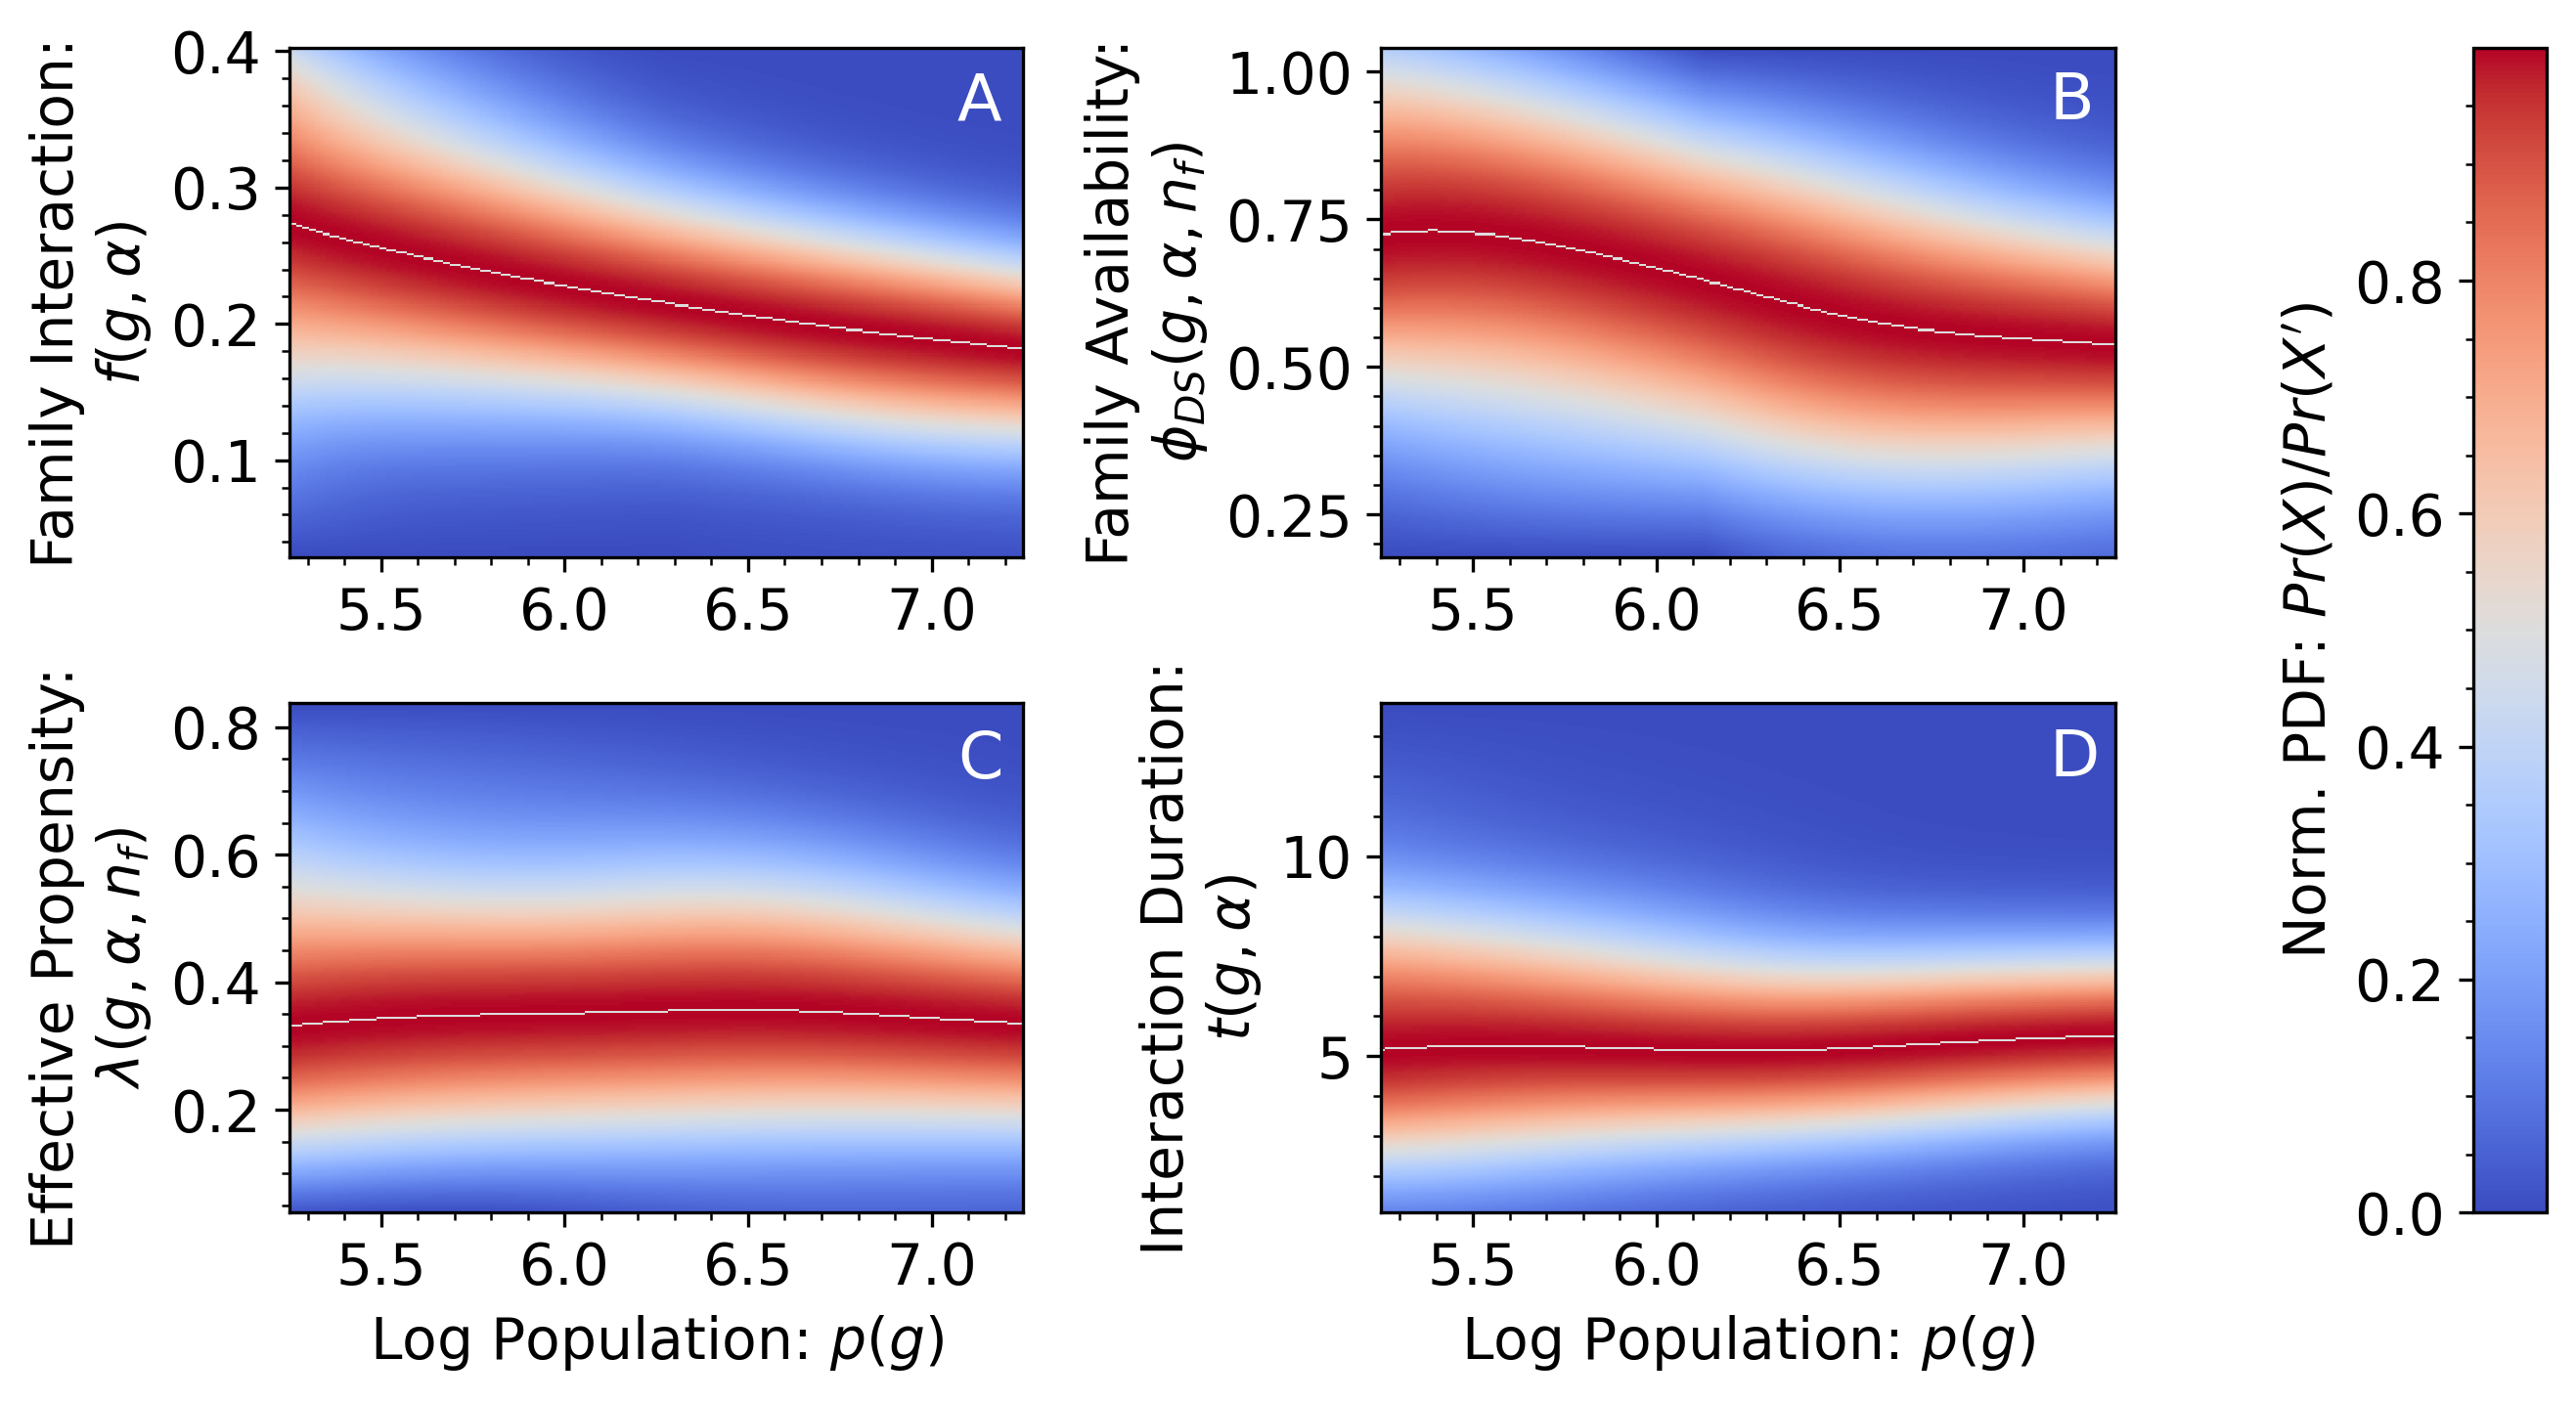

In [51]:
df_tus_trunc = df_tus_trunc_OG.merge(df_calls, on='TUCASEID', how='left').copy()
#df_tus_trunc = df_tus_trunc[df_tus_trunc['TUATTMPTNO']>30]


f_classes = ['None', '1 up to 5', '6 up to 10', '11 up to 20', 'More than 20']

y_fid = 20j
x_fid = 20j
roll = 1
bandwidth = 0.25
kde_exponent = 2
plt.rcParams['font.size'] = 14

trend_line_val = 0.5

padding = 0.05
bandwidth = 0.75
boundary = False


xyzs = []

alpha = 'ALL_TU_H'
#alpha = 'CARE_TU_H'
df_tus_f = calc_f(df_tus_trunc, alpha, 60, 6)
tus_thresh = 1# 50

norm_plot = True

for pew_thresh in [3]: # Pew Sampling
    for ds_thresh in [3]: # Pew DS threshold (# family members)

        df_combined, df_time = get_kde_data(alpha, pew_thresh, ds_thresh, tus_thresh )

        fig = plt.figure(figsize=(9,5), dpi=300, facecolor='white')
        gs = gridspec.GridSpec(2,3, width_ratios=[10,10,1], height_ratios=[1,1])
        ax1 = fig.add_subplot(gs[:1, :1])
        ax2 = fig.add_subplot(gs[:1, 1:2])
        ax3 = fig.add_subplot(gs[1:, :1])
        ax4 = fig.add_subplot(gs[1:, 1:2])
        ax5 = fig.add_subplot(gs[:, -1:])

        # plot f(g) KDE
        X, Y, x_array, y_array, positions = get_kde_matrices(df_combined, 'LOG_POP', f'f(g, alpha={alpha})', x_fid, y_fid, padding)
        X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=boundary, normalize=norm_plot, contrast_trend=True)
        ax1.pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')
        
        # plot phi(g) KDE
        X, Y, x_array, y_array, positions = get_kde_matrices(df_combined, 'LOG_POP', 'phi_D', x_fid, y_fid, padding)
        X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=boundary, normalize=norm_plot, contrast_trend=True)
        ax2.pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')

        # plot lambda(g) KDE
        X, Y, x_array, y_array, positions = get_kde_matrices(df_combined, 'LOG_POP', 'f/phi', x_fid, y_fid, padding, forced_y_max=0.8)
        X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=boundary, normalize=norm_plot, contrast_trend=True)
        ax3.pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')

        # plot t(g) KDE
        X, Y, x_array, y_array, positions = get_kde_matrices(df_time, 'LOG_POP', alpha[:-2], x_fid, y_fid, padding)
        X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=boundary, normalize=norm_plot, contrast_trend=True)
        ax4.pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')


        cmap = mpl.cm.coolwarm
        norm = mpl.colors.Normalize(vmin=Z.min(), vmax=Z.max())

        cb1 = mpl.colorbar.ColorbarBase(ax5, cmap=cmap,
                                        norm=norm,
                                        orientation='vertical')

        cb1.set_label("Norm. PDF: $Pr(X) / Pr(X')$")
        ax5.yaxis.set_ticks_position('left')
        ax5.yaxis.set_label_position('left')

        ax1.set_xlim(5.25,7.25)
        ax2.set_xlim(ax1.axis()[0], ax1.axis()[1])
        ax3.set_xlim(ax1.axis()[0], ax1.axis()[1])
        ax4.set_xlim(ax1.axis()[0], ax1.axis()[1])


        ax1.set_ylabel('Family Interaction:\n$f(g, \\alpha)$')
        ax2.set_ylabel('Family Availability:\n$\phi_{DS}(g, \\alpha, n_f)$')
        ax3.set_ylabel('Effective Propensity:\n$\lambda(g, \\alpha, n_f)$')
        ax4.set_ylabel('Interaction Duration:\n$t(g, \\alpha)$')
        ax3.set_xlabel('Log Population: $p(g)$')
        ax4.set_xlabel('Log Population: $p(g)$')

        ax1.text(7.07,0.35, 'A', color='white', fontsize=16)
        ax2.text(7.07,0.92, 'B', color='white', fontsize=16)
        ax3.text(7.07,0.72, 'C', color='white', fontsize=16)
        ax4.text(7.07,12, 'D', color='white', fontsize=16)
        
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax2.xaxis.set_minor_locator(AutoMinorLocator())
        ax3.xaxis.set_minor_locator(AutoMinorLocator())
        ax4.xaxis.set_minor_locator(AutoMinorLocator())

        ax1.yaxis.set_minor_locator(AutoMinorLocator())
        ax2.yaxis.set_minor_locator(AutoMinorLocator())
        ax3.yaxis.set_minor_locator(AutoMinorLocator())
        ax4.yaxis.set_minor_locator(AutoMinorLocator())
        ax5.yaxis.set_minor_locator(AutoMinorLocator())

        plt.tight_layout()
        #filename = f.replace(' ','_') + '_n=>'+str(t+1)+'.png'
        #plt.savefig('/Users/jericho/Documents/csi/csi-research/Notebooks/MKL_2_notebooks/images/KDE_'+filename)
        plt.show()

## 20-panel KDE

tus_count=1, bandwidth=0.5, pew_count=1, ds_thresh=3


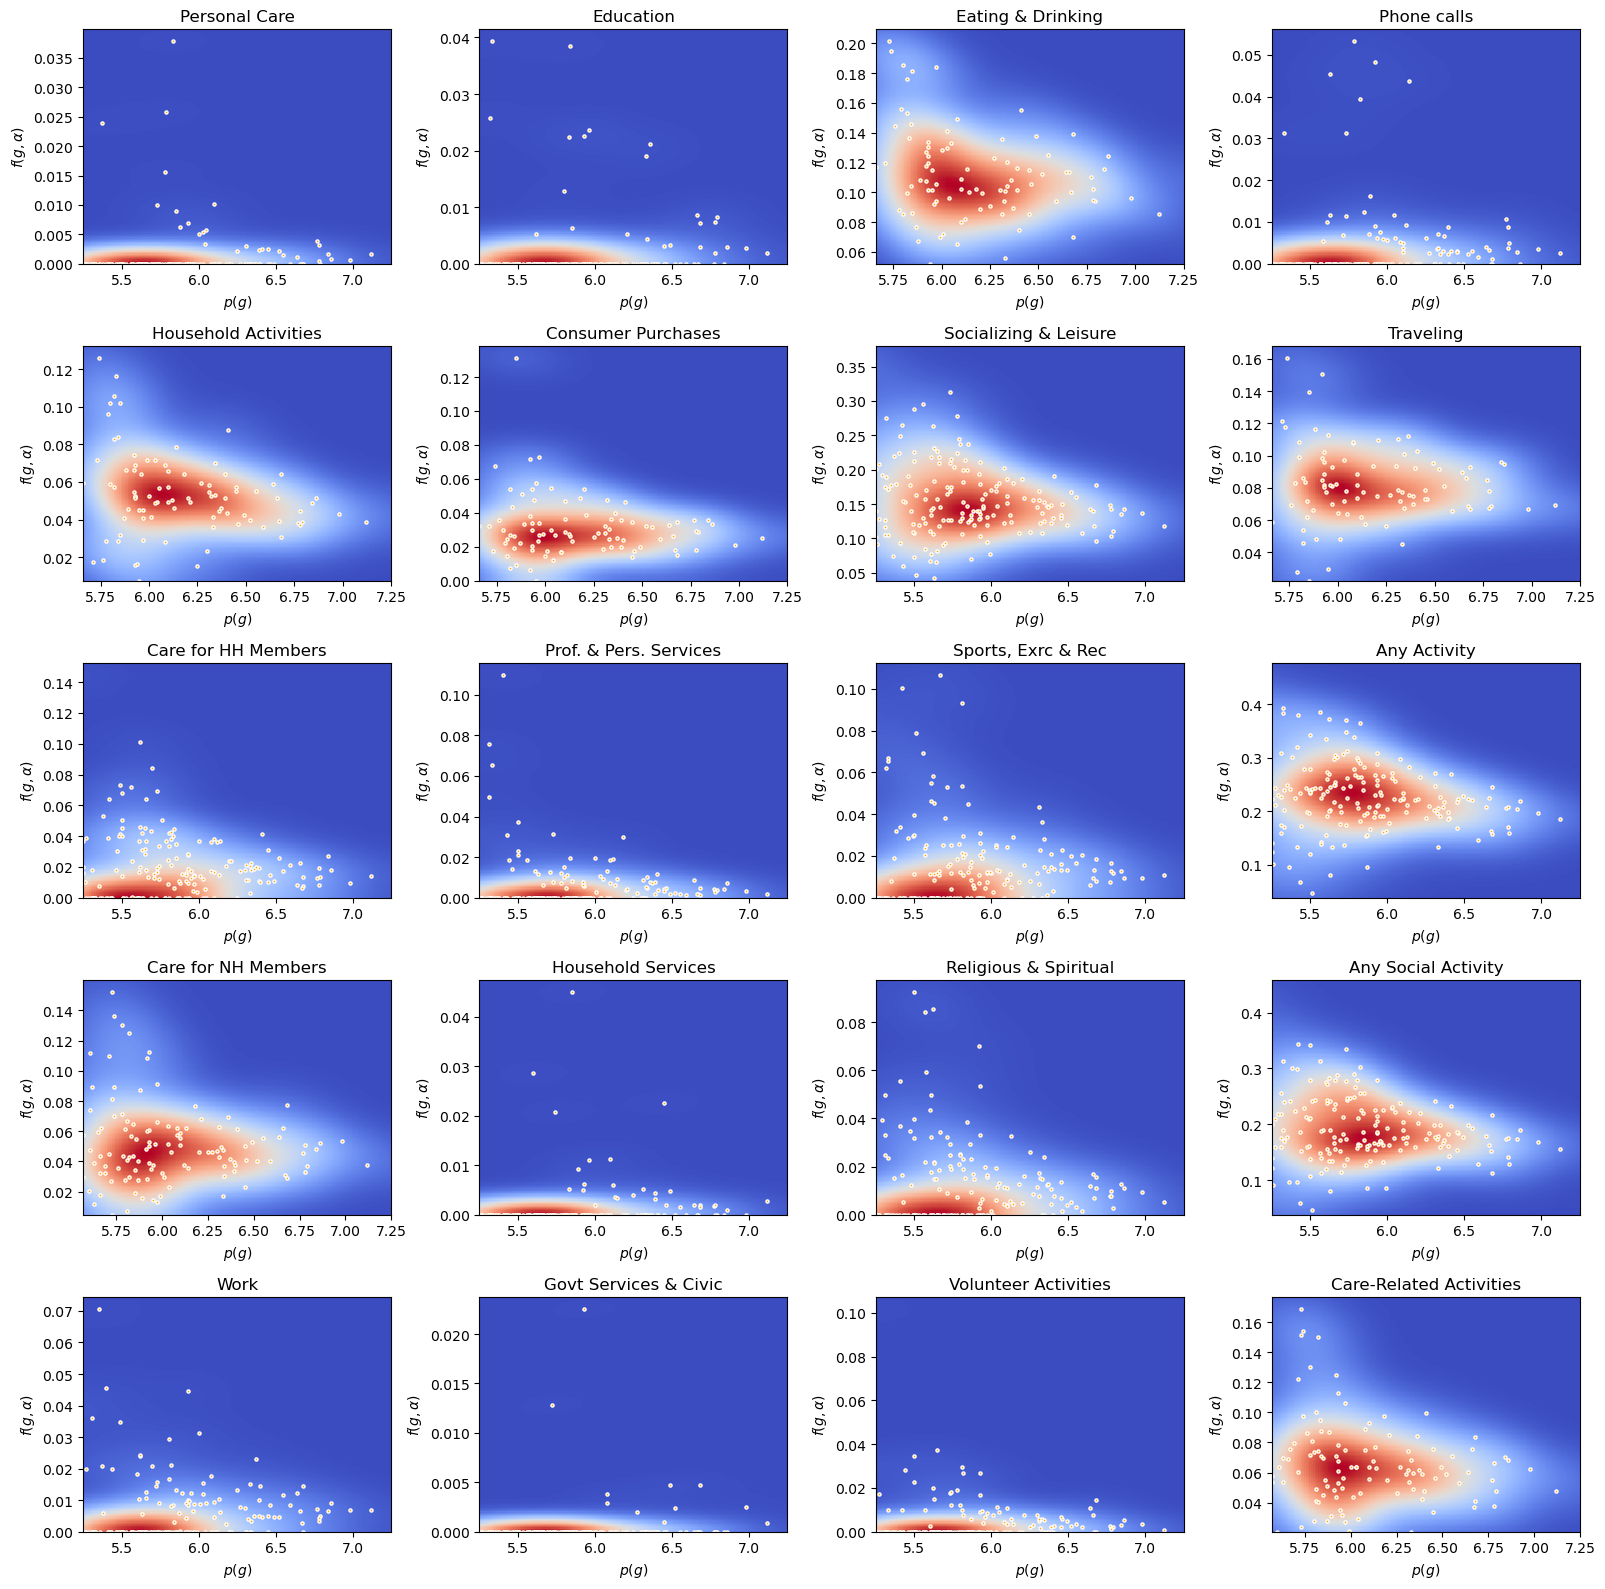

In [52]:
plt.rcParams['font.size'] = 10


y_fid = 20j
x_fid = 20j
norm_plot = False
tus_thresh = 1
bwidth = [0.5]
scatter = True

for bandwidth in bwidth:#[i/5 for i in range(1,6)]:
    for pew_thresh in [1]: # Pew Sampling


        for ds_thresh in [3]: # Pew DS threshold (# family members)
            print(f'tus_count={tus_thresh}, bandwidth={bandwidth}, pew_count={pew_thresh}, ds_thresh={ds_thresh}')

            fig, axes = plt.subplots(5, 4,figsize=(16,16), dpi=100, facecolor='white',)

            for a in range(len(alphas)):
                alpha = alphas[a]
                tus_thresh = s_filters_by_alpha[alpha]
                x = a % 5
                y = a // 5
                ax1 = axes[x,y]
                df_combined, df_time = get_kde_data(alpha, pew_thresh, ds_thresh, tus_thresh)
                
                X, Y, x_array, y_array, positions = get_kde_matrices(df_combined, 'LOG_POP', f'f(g, alpha={alpha})', x_fid, y_fid, padding)
                X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=True, normalize=norm_plot, contrast_trend=True)
                    

                ax1.pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')
                if scatter:
                    ax1.scatter(x_array, y_array, s=5, edgecolors='white', facecolor='orange')
                ax1.set_ylim(max(0, min(y_array)),)
                ax1.set_xlim(max(5.25, min(x_array)),7.25)
                ax1.set_ylabel('$f(g,\\alpha)$')
                ax1.set_xlabel('$p(g)$')
                ax1.set_title(codes[alpha])

            plt.tight_layout()
            plt.show()

### Filter non-zero

tus_count=25, bandwidth=0.75, pew_count=3, ds_thresh=3


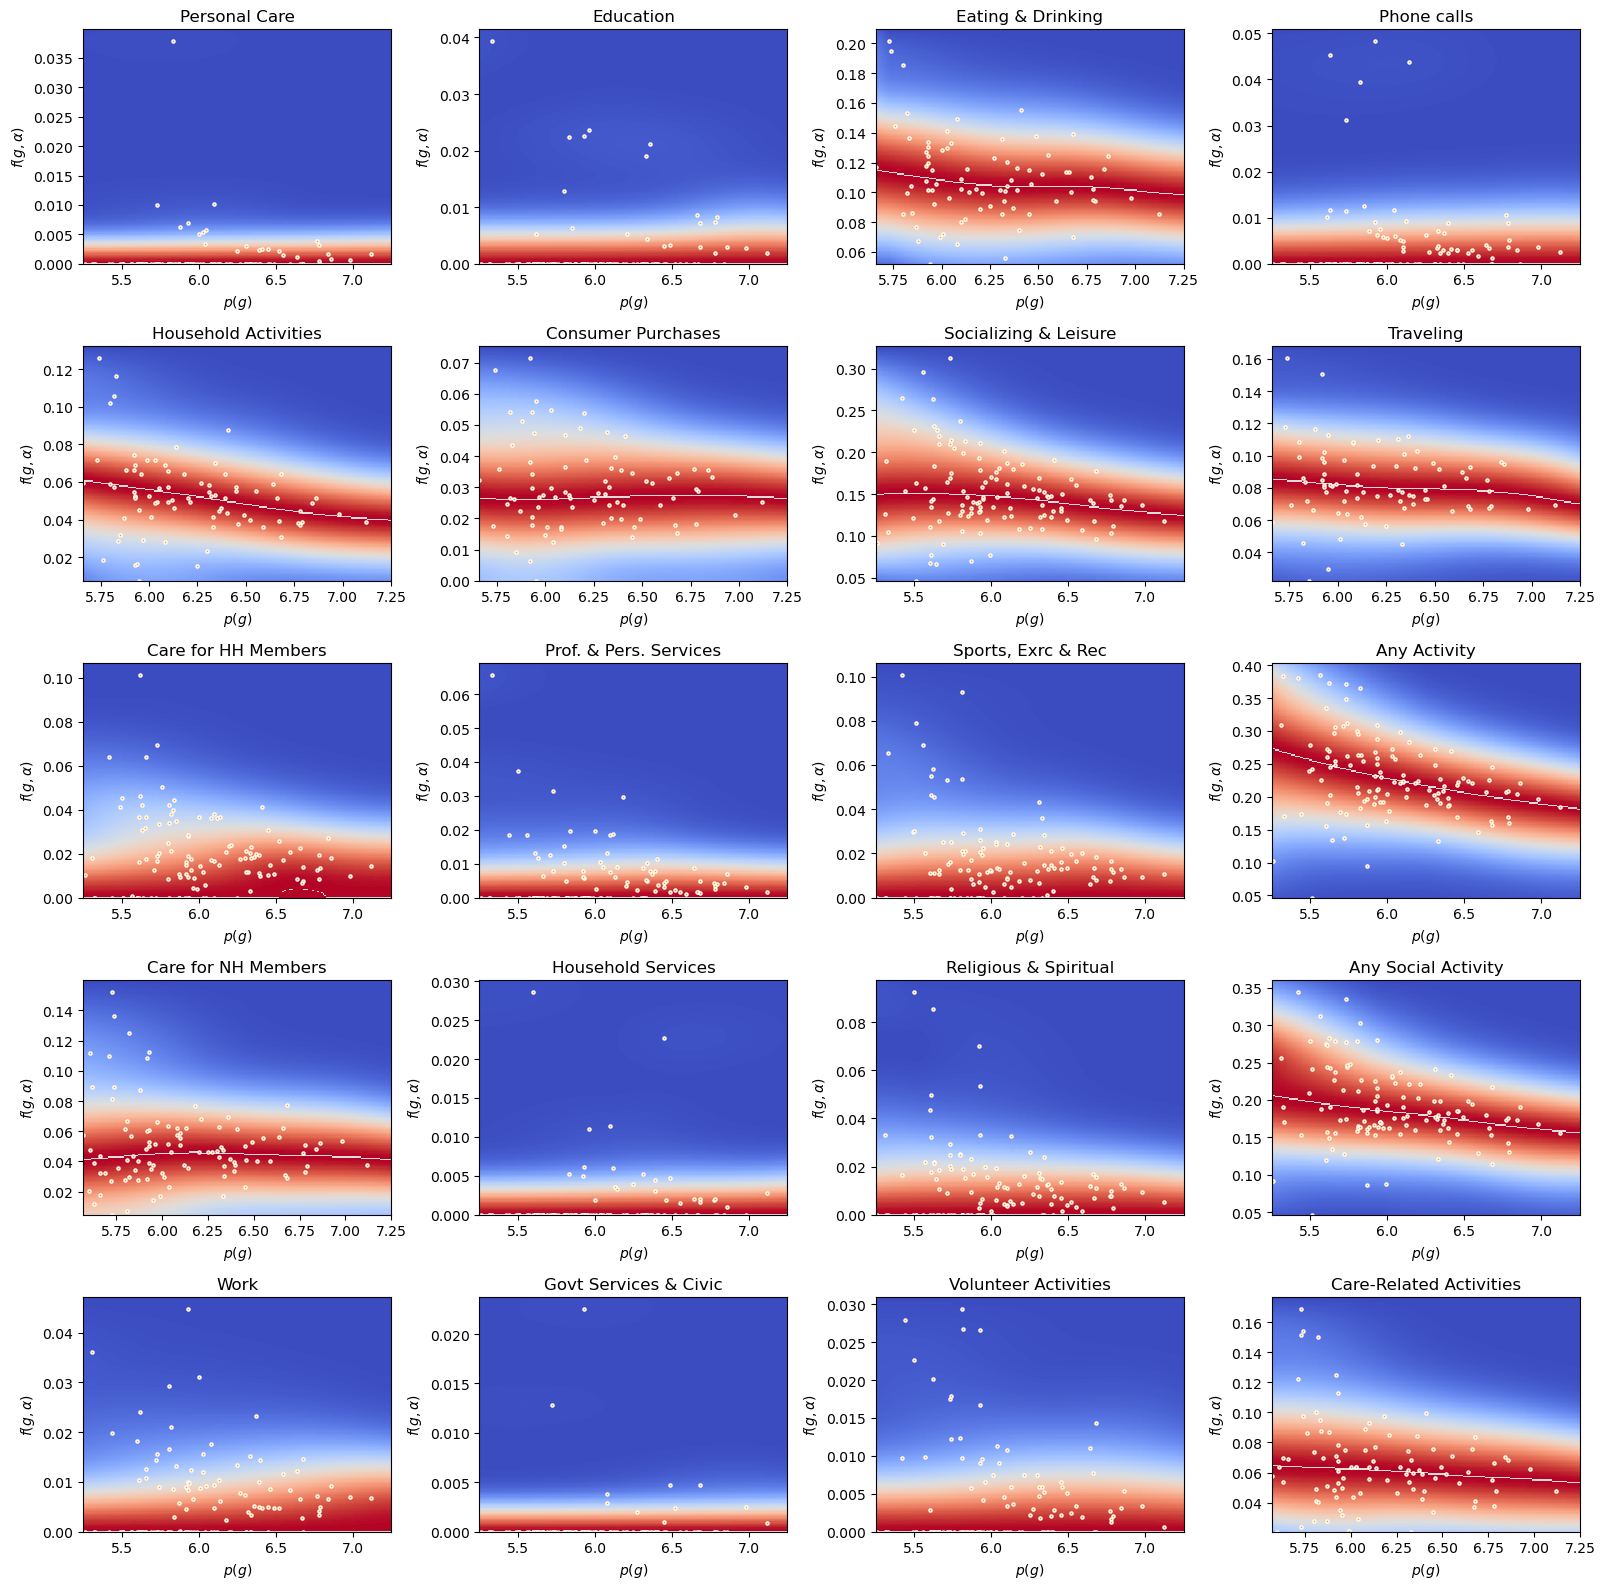

In [53]:
plt.rcParams['font.size'] = 10


y_fid = 20j
x_fid = 20j
norm_plot = True
tus_thresh = 25
bandwidth = 0.75
scatter = True

for bandwidth in [0.75]:#[i/5 for i in range(1,6)]:
    for pew_thresh in [3]: # Pew Sampling


        for ds_thresh in [3]: # Pew DS threshold (# family members)
            print(f'tus_count={tus_thresh}, bandwidth={bandwidth}, pew_count={pew_thresh}, ds_thresh={ds_thresh}')

            fig, axes = plt.subplots(5, 4,figsize=(16,16), dpi=100, facecolor='white',)

            for a in range(len(alphas)):
                alpha = alphas[a]
                tus_thresh = s_filters_by_alpha[alpha]
                x = a % 5
                y = a // 5
                ax1 = axes[x,y]
                df_combined, df_time = get_kde_data(alpha, pew_thresh, ds_thresh, tus_thresh)#, w=False)
                
                # if df_combined[f'f(g, alpha={alpha})'].sum()/len(df_combined) < 0.05:
                #     df_combined = df_combined[df_combined[f'f(g, alpha={alpha})']>0]

                #     X, Y, x_array, y_array, positions = get_kde_matrices(df_combined, 'LOG_POP', f'f(g, alpha={alpha})', x_fid, y_fid, padding)
                #     X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=False, normalize=norm_plot, contrast_trend=True)
                # else:
                #     X, Y, x_array, y_array, positions = get_kde_matrices(df_combined, 'LOG_POP', f'f(g, alpha={alpha})', x_fid, y_fid, padding)
                #     X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=True, normalize=norm_plot, contrast_trend=True)

                X, Y, x_array, y_array, positions = get_kde_matrices(df_combined, 'LOG_POP', f'f(g, alpha={alpha})', x_fid, y_fid, padding)
                X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=True, normalize=norm_plot, contrast_trend=True)
                    

                ax1.pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')
                if scatter:
                    ax1.scatter(x_array, y_array, s=5, edgecolors='white', facecolor='orange')
                ax1.set_ylim(max(0, min(y_array)),)
                ax1.set_xlim(max(5.25, min(x_array)),7.25)
                ax1.set_ylabel('$f(g,\\alpha)$')
                ax1.set_xlabel('$p(g)$')
                ax1.set_title(codes[alpha])

            plt.tight_layout()
            plt.show()


### Deep exploration

In [54]:
# plt.rcParams['font.size'] = 10



# trend_lines = {}
# cbsa_counts = {}
# df_dict = {}

# y_fid = 200j
# x_fid = 200j
# norm_plot = True
# tus_thresh = 1
# bandwidth = 0.75
# scatter = True

# for bandwidth in [bandwidth]:#[i/5 for i in range(1,6)]:
#     for pew_thresh in [1,5,10,15,20]: # Pew Sampling
#         df_dict[pew_thresh] = {}
#         trend_lines[pew_thresh] = {}
#         cbsa_counts[pew_thresh] = {}

#         for ds_thresh in [1,2,3,4,5]: # Pew DS threshold (# family members)
#             print(f'bandwidth={bandwidth}, pew_count={pew_thresh}, ds_thresh={ds_thresh}')
#             df_dict[pew_thresh][ds_thresh] = {}
#             trend_lines[pew_thresh][ds_thresh] = {}
#             cbsa_counts[pew_thresh][ds_thresh] = {}
#             #fig, axes = plt.subplots(5, 4,figsize=(16,16), dpi=100, facecolor='white',)



#             for a in range(len(alphas)):
#                 alpha = alphas[a]
#                 tus_thresh = s_filters_by_alpha[alpha]
#                 x = a % 5
#                 y = a // 5
#                 ax1 = axes[x,y]
#                 df_combined, df_time = get_kde_data(alpha, pew_thresh, ds_thresh, tus_thresh)
#                 df_dict[pew_thresh][ds_thresh][alpha] = df_combined
#                 trend_lines[pew_thresh][ds_thresh][alpha] = {}

#                 X, Y, x_array, y_array, positions = get_kde_matrices(df_combined, 'LOG_POP', f'f(g, alpha={alpha})', x_fid, y_fid, padding)
#                 X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=True, normalize=norm_plot, contrast_trend=True)
#                 if norm_plot:
#                     trend_lines[pew_thresh][ds_thresh][alpha]['f(g)'] = trend
                
#                 # plot phi(g) KDE
#                 X, Y, x_array, y_array, positions = get_kde_matrices(df_combined, 'LOG_POP', 'phi_D', x_fid, y_fid, padding)
#                 X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=True, normalize=norm_plot, contrast_trend=True)
#                 if norm_plot:
#                     trend_lines[pew_thresh][ds_thresh][alpha]['phi_ds(g)'] = trend

#                 # plot lambda(g) KDE
#                 X, Y, x_array, y_array, positions = get_kde_matrices(df_combined, 'LOG_POP', 'f/phi', x_fid, y_fid, padding, forced_y_max=0.8)
#                 X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=True, normalize=norm_plot, contrast_trend=True)
#                 if norm_plot:
#                     trend_lines[pew_thresh][ds_thresh][alpha]['lambda(g)'] = trend

#                 # plot t(g) KDE
#                 X, Y, x_array, y_array, positions = get_kde_matrices(df_time, 'LOG_POP', alpha[:-2], x_fid, y_fid, padding)
#                 X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=True, normalize=norm_plot, contrast_trend=True)
#                 if norm_plot:
#                     trend_lines[pew_thresh][ds_thresh][alpha]['t(g)'] = trend


#                 cbsa_counts[pew_thresh][ds_thresh][alpha] = len(df_combined)



#### Variable analysis

In [55]:
# print('Pew Thresholds:',trend_lines.keys())
# print('DS Thresholds:',trend_lines[1].keys())
# print('Alphas',trend_lines[1][1].keys())
# print('KDE Trends',trend_lines[1][1]['ALL_TU_H'].keys())

In [56]:
# var = 'lambda(g)'

# colors = ['blue','green','red','purple','orange']
# linestyles = ['-','--',':','-.',(0, (3, 5, 1, 5))]

# pew_threshes = list(trend_lines.keys())
# ds_threshes = list(trend_lines[1].keys())

# for alpha in alphas[17:18]:
#     plt.figure(figsize=(8,6),facecolor='white')
#     for pew_thresh, tdict in trend_lines.items():
#         for ds_thresh, ttdict in tdict.items():
#             #print(pew_thresh, ds_thresh, alpha)
#             plt.plot(ttdict[alpha][var][0],
#                     ttdict[alpha][var][1], 
#                     label=f'Pew_{pew_thresh} DS_{ds_thresh}', 
#                     color=colors[pew_threshes.index(pew_thresh)], 
#                     linestyle=linestyles[ds_threshes.index(ds_thresh)])
#     plt.title(codes[alpha])
#     plt.legend(bbox_to_anchor=(1,1.05))
#     plt.show()

# TO DO

1. (DONE) Fig 1 (done: 4 panel plot of All )
2. (DONE) Fig 2: Scale Any, Social, and Care trendlines, f(g), lambda(g) <- scaled, t(g) (maybe scaled - try it out)
3. (DONE) Regression table: for f(g) & lambda(g) (for the good plots)
4. Fig 3: Phi_DS w/ varied n_f- do 2 panels w/ lambdas included to show the effect 
5. Scatter plot scaling All/Social/Care, then 2nd scatter scaling All against one of the issue alphas like Sports to show the portion of the arrowhead that is present
6. Add boxplot updates
7. Bootstrap KDE error


## 4 Panel Plot data for Any, Social, and Care

In [57]:
df_time

GTCBSA  NEW_WEIGHT   CARE_TU  LOG_POP
0     10420     10845.0  2.598571     5.85
1     10580     27005.0  2.432235     5.94
2     10740     43819.0  4.175411     5.96
3     10900     39719.0  1.174625     5.92
4     11100      9154.0  0.166667     5.42
..      ...         ...       ...      ...
204   49180     72089.0  2.348501     5.82
205   49340     59402.0  0.980656     5.97
206   49620     21502.0  1.621674     5.65
207   49660     46181.0  1.226661     5.73
208   49740     15534.0  1.048372     5.32

[209 rows x 4 columns]

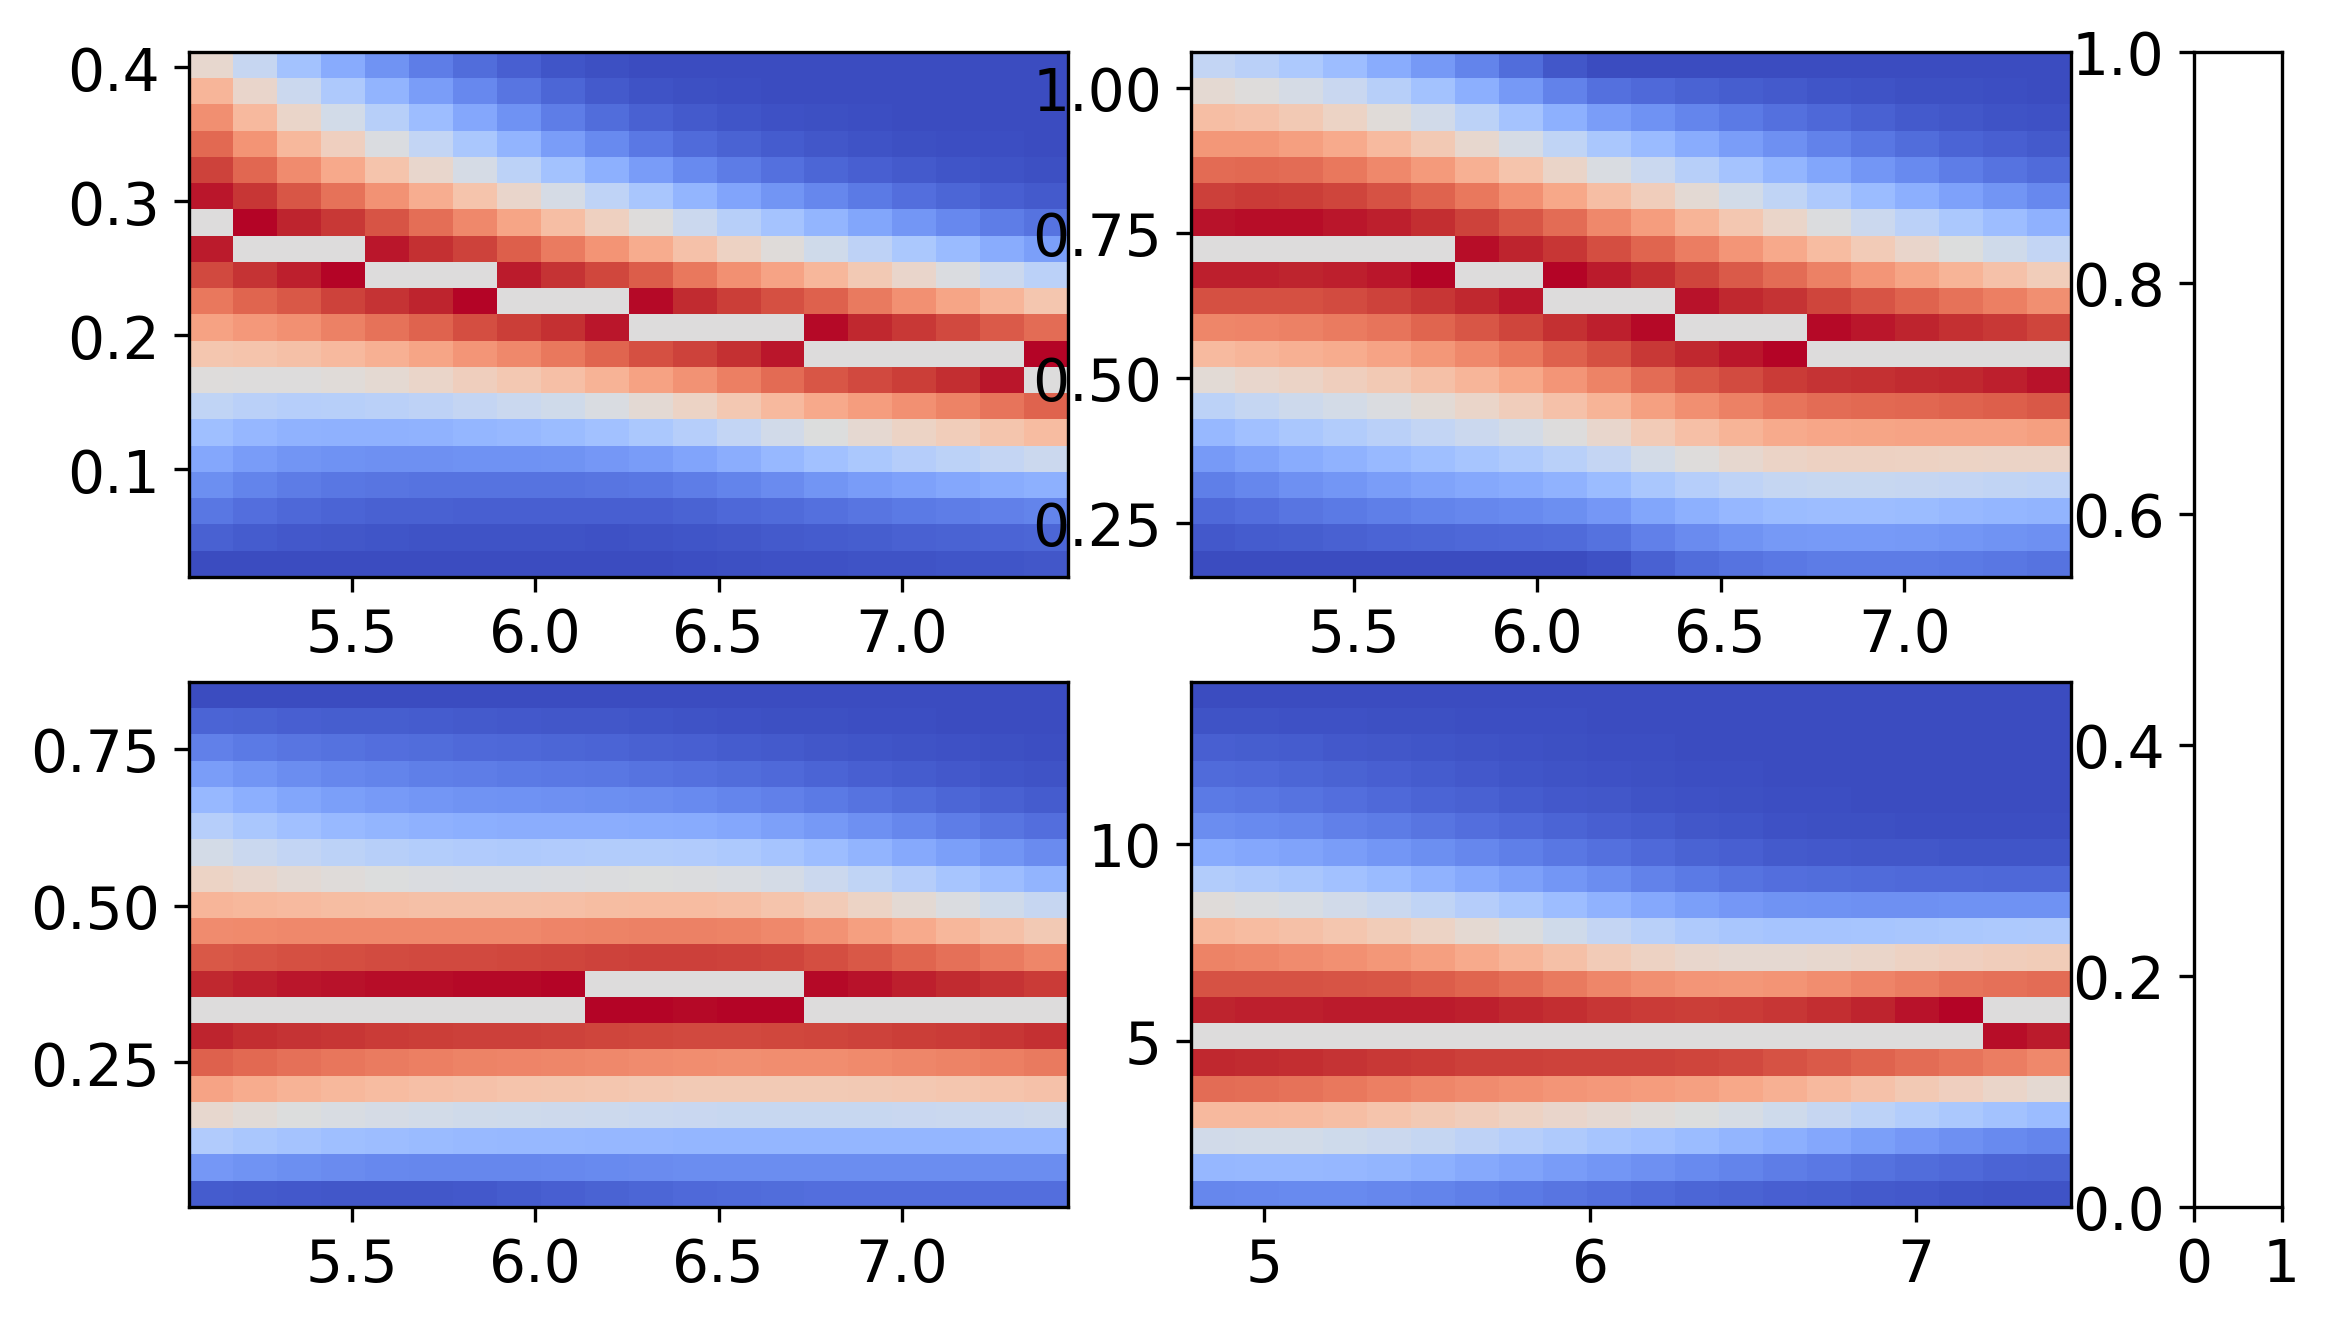

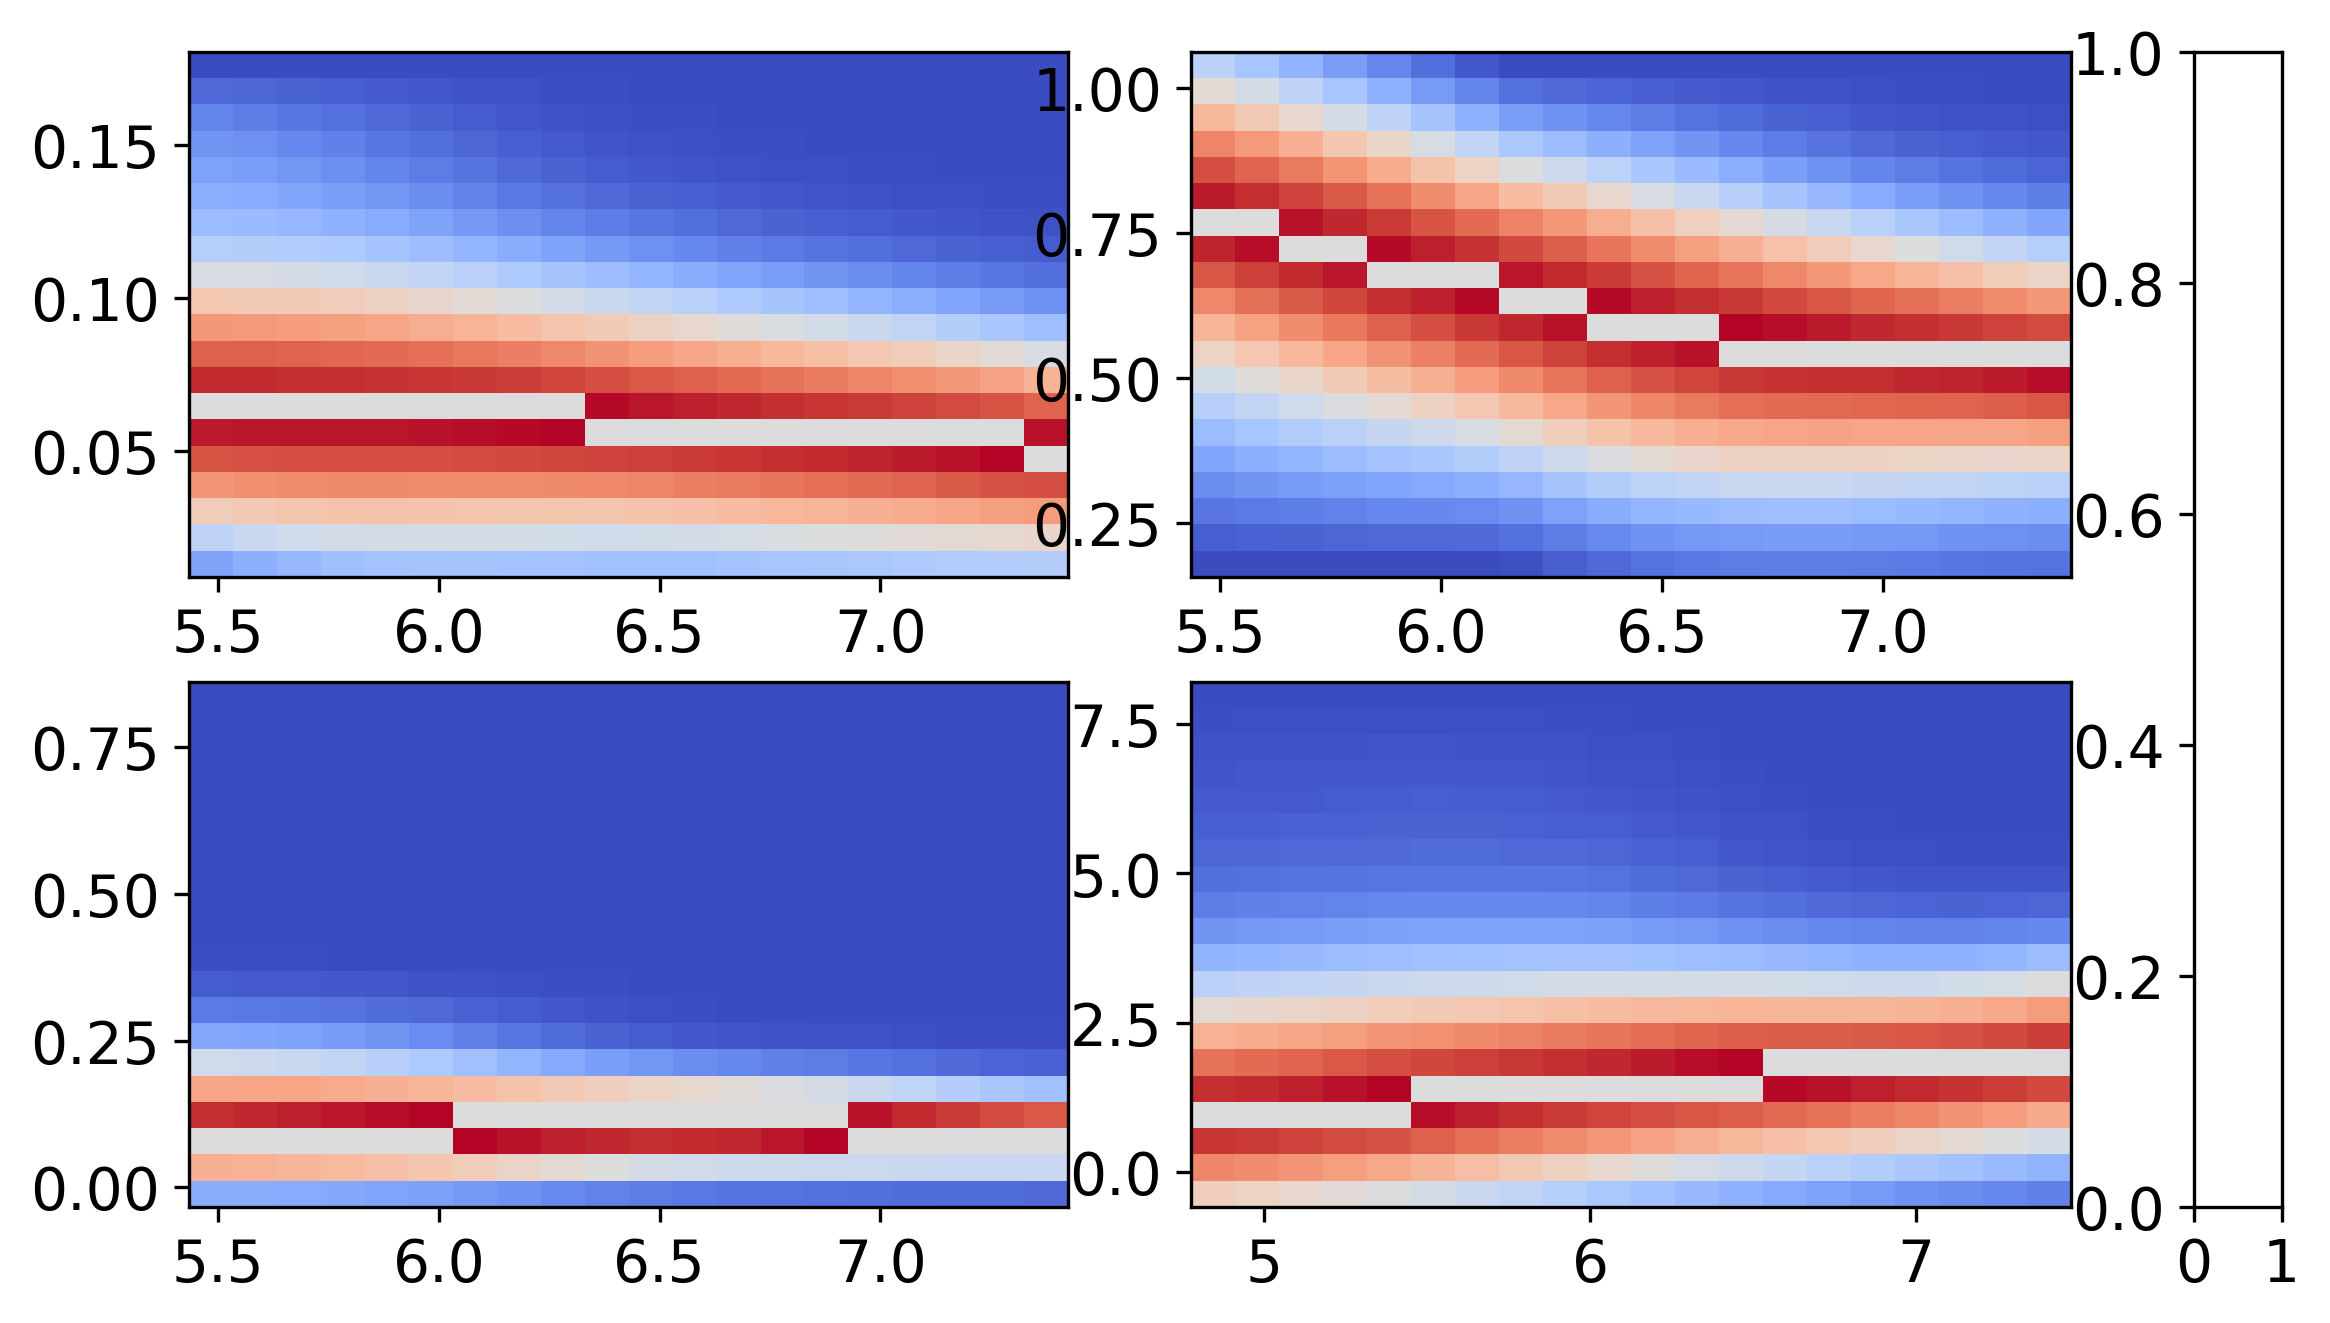

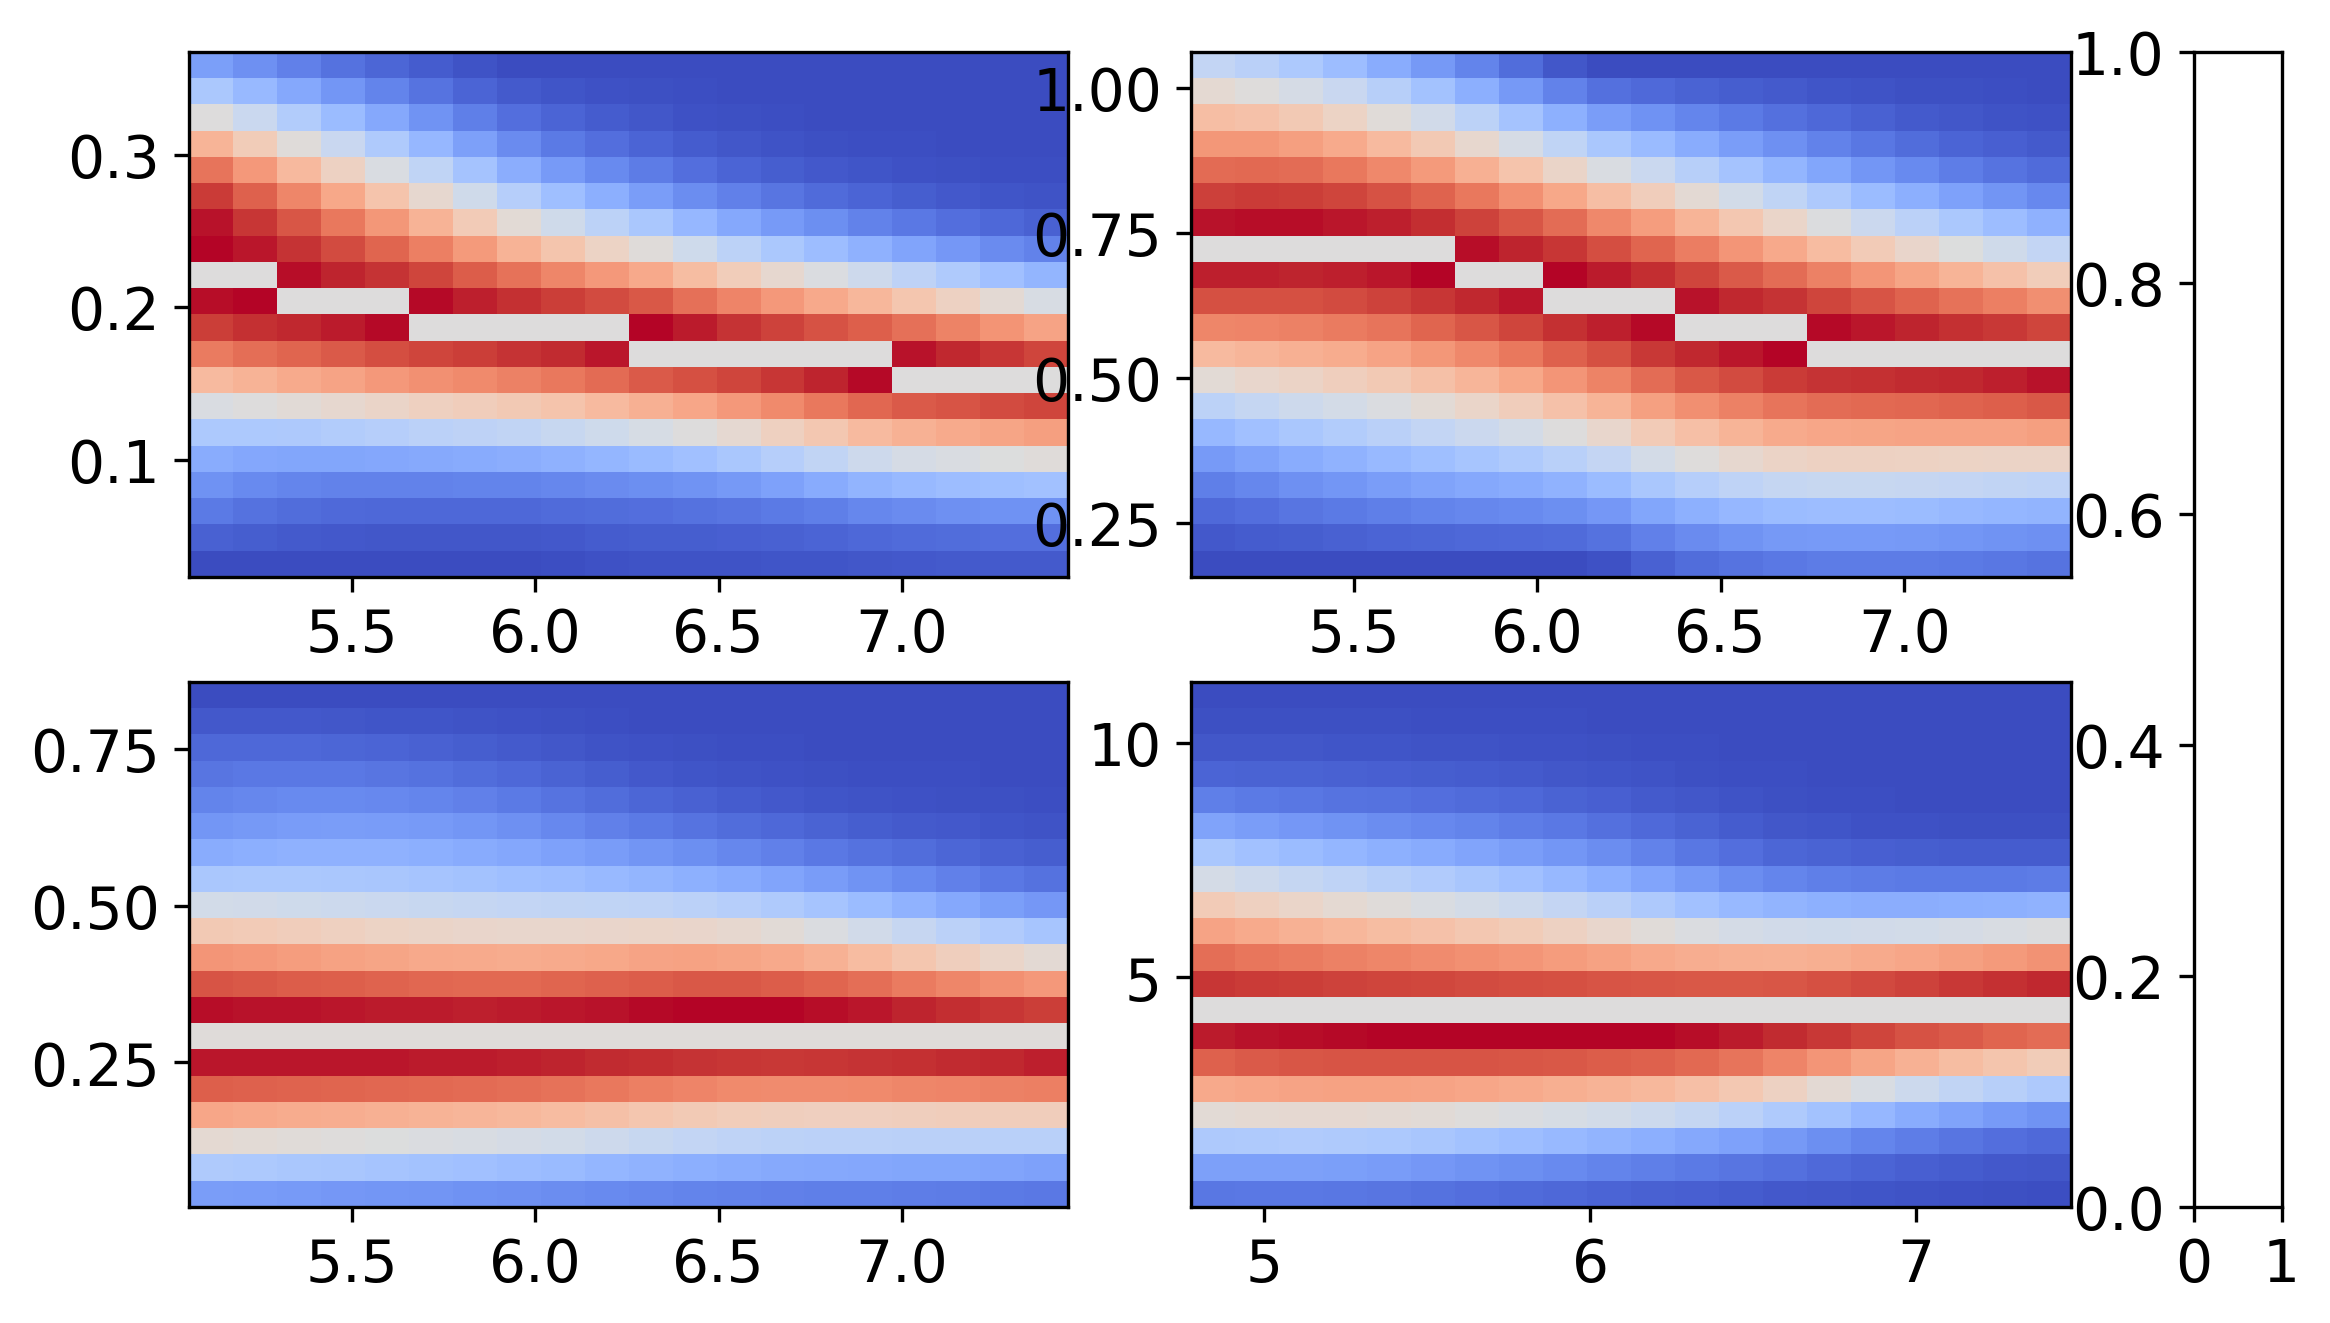

In [58]:
df_tus_trunc = df_tus_trunc_OG.merge(df_calls, on='TUCASEID', how='left').copy()
#df_tus_trunc = df_tus_trunc[df_tus_trunc['TUATTMPTNO']>30]


f_classes = ['None', '1 up to 5', '6 up to 10', '11 up to 20', 'More than 20']

y_fid = 20j
x_fid = 20j
plt.rcParams['font.size'] = 14

trend_line_val = 0.5

padding = 0.05
bandwidth = 0.8

xyzs = []

alpha = 'ALL_TU_H'
df_tus_f = calc_f(df_tus_trunc, alpha, 60, 6)
tus_thresh = 1

norm_plot = True

trend_data_4panel = {}

for alpha in ['ALL_TU_H','CARE_TU_H','SOCIAL_TU_H']:
    trend_data_4panel[alpha] = {}
    for pew_thresh in [3]: # Pew Sampling
        for ds_thresh in [3]: # Pew DS threshold (# family members)
            if alpha == 'CARE_TU_H':
                tus_thresh = 50
            elif alpha == 'SOCIAL_TU_H':
                tus_thresh = 0
            else:
                tus_thresh = 0

            df_combined, df_time = get_kde_data(alpha, pew_thresh, ds_thresh, tus_thresh )

            fig = plt.figure(figsize=(9,5), dpi=300, facecolor='white')
            gs = gridspec.GridSpec(2,3, width_ratios=[10,10,1], height_ratios=[1,1])
            ax1 = fig.add_subplot(gs[:1, :1])
            ax2 = fig.add_subplot(gs[:1, 1:2])
            ax3 = fig.add_subplot(gs[1:, :1])
            ax4 = fig.add_subplot(gs[1:, 1:2])
            ax5 = fig.add_subplot(gs[:, -1:])

            # plot f(g) KDE
            X, Y, x_array, y_array, positions = get_kde_matrices(df_combined, 'LOG_POP', f'f(g, alpha={alpha})', x_fid, y_fid, padding)
            X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=False, normalize=norm_plot, contrast_trend=True)
            ax1.pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')
            trend_data_4panel[alpha]['f(g)'] = trend
            
            # plot phi(g) KDE
            X, Y, x_array, y_array, positions = get_kde_matrices(df_combined, 'LOG_POP', 'phi_D', x_fid, y_fid, padding)
            X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=False, normalize=norm_plot, contrast_trend=True)
            ax2.pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')
            trend_data_4panel[alpha]['phi(g)'] = trend

            # plot lambda(g) KDE
            X, Y, x_array, y_array, positions = get_kde_matrices(df_combined, 'LOG_POP', 'f/phi', x_fid, y_fid, padding, forced_y_max=0.8)
            X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=False, normalize=norm_plot, contrast_trend=True)
            ax3.pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')
            trend_data_4panel[alpha]['lambda(g)'] = trend

            # plot t(g) KDE
            X, Y, x_array, y_array, positions = get_kde_matrices(df_time, 'LOG_POP', alpha[:-2], x_fid, y_fid, padding)
            X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=False, normalize=norm_plot, contrast_trend=True)
            ax4.pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')
            trend_data_4panel[alpha]['t(g)'] = trend


## 3 panel scaled plots

In [59]:
def add_subplot_axes(fig, ax, rect, xticks, yticks):
    
    box = ax.get_position()
    x0 = box.x0
    y0 = box.y0
    x1 = box.x1
    y1 = box.y1
    xrang = x1-x0
    yrang = y1-y0
    x = rect[0] * xrang + x0
    y = rect[1] * yrang + y0
    w = xrang * rect[2]
    h = yrang * rect[3]
    subax = fig.add_axes([x,y,w,h])
    subax.tick_params(axis='both', which='major', labelsize=12)
    subax.xaxis.set_minor_locator(AutoMinorLocator())
    subax.yaxis.set_minor_locator(AutoMinorLocator())
    subax.tick_params(which='minor', length=3, width=1)
    subax.tick_params(which='major', length=4, width=1.5)
    subax.set_xticks(xticks)
    subax.set_yticks(yticks)
    #subax.grid(visible=True, which='both', axis='both')
    return subax

In [60]:
def midpoint_lines(x,y):
    xo,yo = [],[]
    xs = []
    y1 = y[0]
    for i in range(len(y)):
        if y[i] == y1:
            xs.append(x[i])
        else:
            xo.append(sum(xs)/len(xs))
            yo.append(y1)
            y1 = y[i]
            xs = [x[i]]
    xo.append(sum(xs)/len(xs))
    yo.append(y1)
    return xo, yo
    

/var/folders/qv/9w3wskgd1pj1k5ffzq67k54c0000gn/T/ipykernel_62051/239183053.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/qv/9w3wskgd1pj1k5ffzq67k54c0000gn/T/ipykernel_62051/239183053.py:109: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


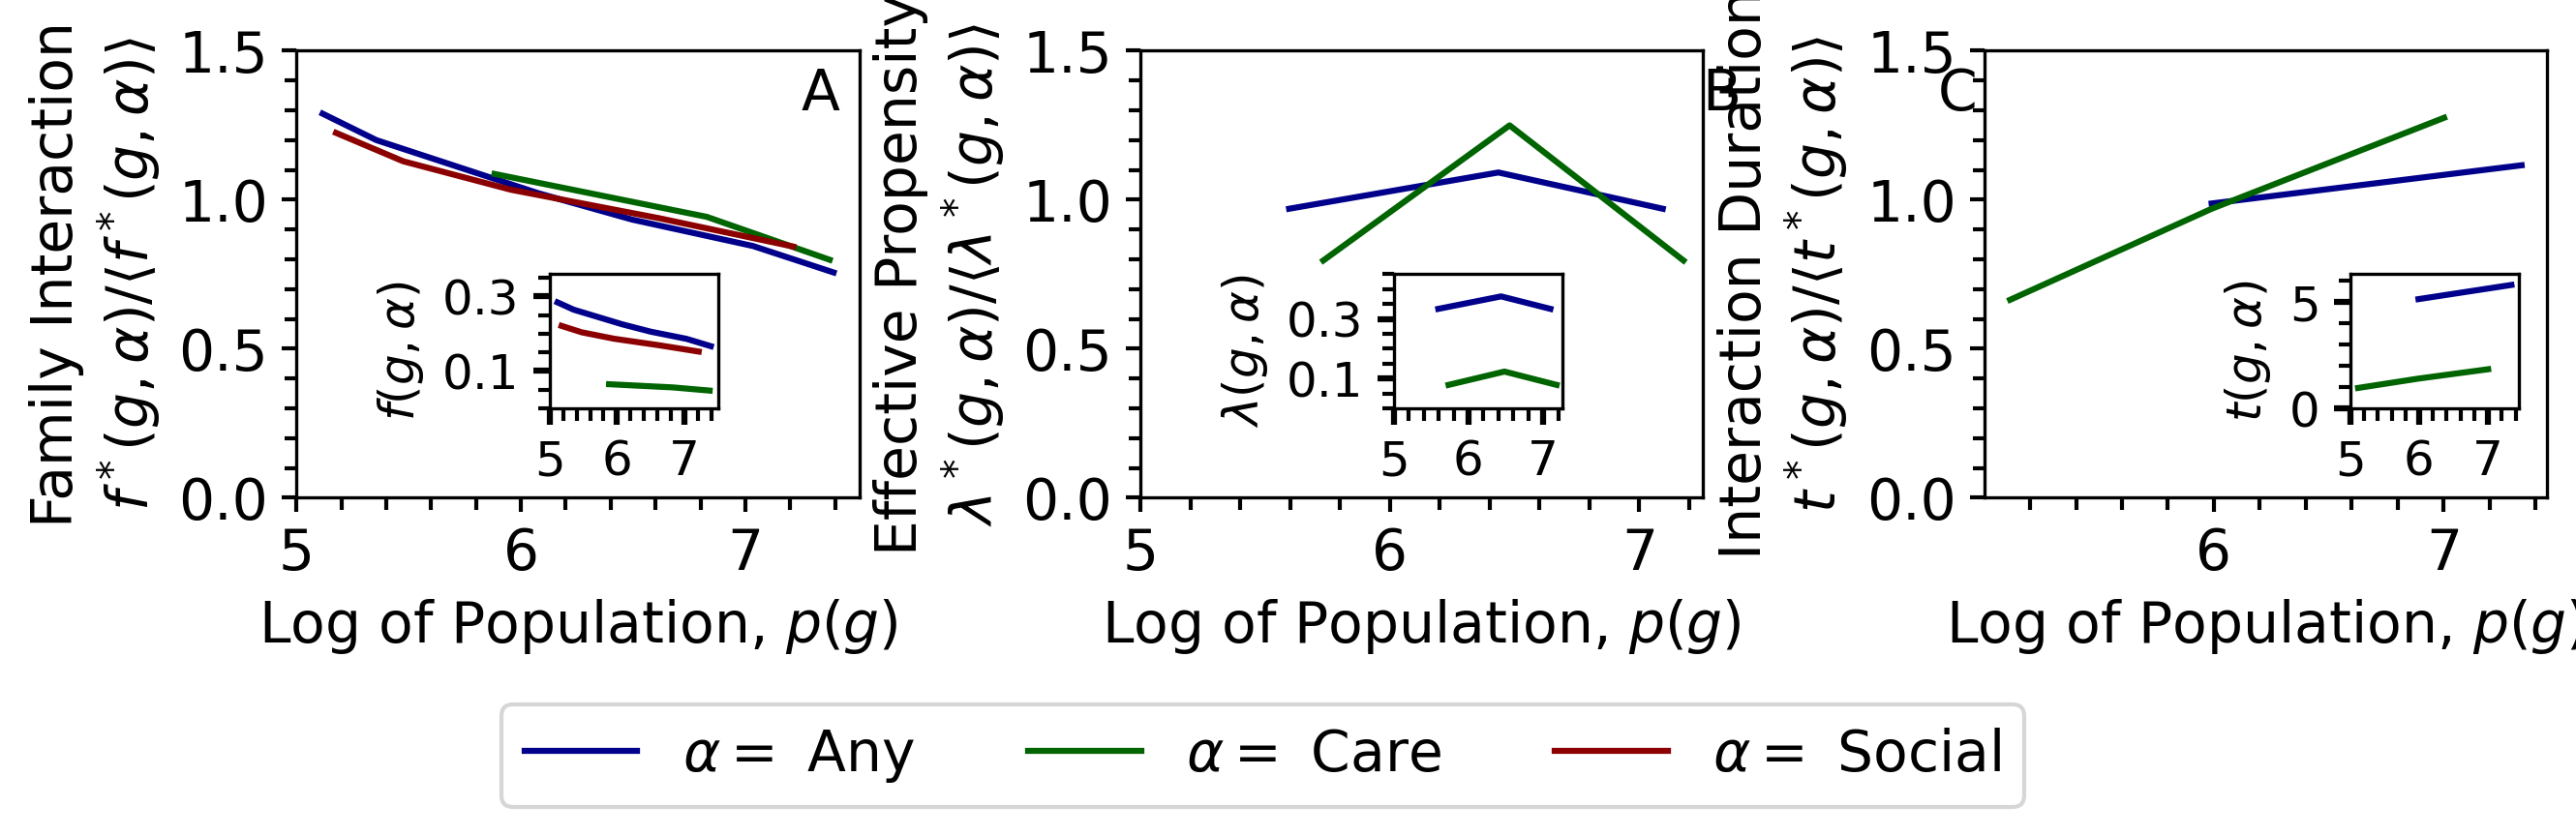

In [61]:
# print(trend_data_4panel.keys())
# print(trend_data_4panel['ALL_TU_H'].keys())

fig, ax = plt.subplots(1,3, figsize=(10,2), dpi=300, facecolor='white')
fig.subplots_adjust(wspace=0.5)

#ax[0].set_xlim(5.5,7.4)

colors = ['darkblue','darkgreen','darkred']

vars = ['f(g)', 'lambda(g)', 't(g)']
boxes = [[0.45, 0.2, 0.3, 0.3], 
        [0.45, 0.2, 0.3, 0.3], 
        [0.65, 0.2, 0.3, 0.3]]

d1,d2,d3,d4,d5,d6 = [],[],[],[],[],[]


ylims = [(0, 1.5), (0, 1.5), (0, 1.5)]
ylimsub = [(0, 0.4), (0, 0.5), (0, 7)]
xticks = [[5, 6,7],[5,6,7],[5,6,7]]
yticks = [[0.1,0.3], [0.1, 0.3], [0,5]]
inset_ylab = ['$f(g,\\alpha)$  ', '$\lambda(g,\\alpha)$  ', '$t(g,\\alpha)$  ']

for i in range(len(vars)):
    y1 = trend_data_4panel['ALL_TU_H'][vars[i]][1]
    y2 = trend_data_4panel['CARE_TU_H'][vars[i]][1]
    y3 = trend_data_4panel['SOCIAL_TU_H'][vars[i]][1]

    x1 = trend_data_4panel['ALL_TU_H'][vars[i]][0]
    x2 = trend_data_4panel['CARE_TU_H'][vars[i]][0]
    x3 = trend_data_4panel['SOCIAL_TU_H'][vars[i]][0]

    d1.append(vars[i])
    d2.append('All')
    d3.append(min(y1))
    d4.append(max(y1))
    d5.append(min(x1))
    d6.append(max(x1))
    d1.append(vars[i])
    d2.append('Care')
    d3.append(min(y2))
    d4.append(max(y2))
    d5.append(min(x2))
    d6.append(max(x2))
    d1.append(vars[i])
    d2.append('Social')
    d3.append(min(y3))
    d4.append(max(y3))
    d5.append(min(x2))
    d6.append(max(x2))

    y1_mean = sum(y1)/len(y1)
    y2_mean = sum(y2)/len(y2)
    y3_mean = sum(y3)/len(y3)
    # y1 = [i/(y1_mean/y1_mean) for i in y1]
    # y2 = [i/(y2_mean/y1_mean) for i in y2]
    # y3 = [i/(y3_mean/y1_mean) for i in y3]
    y1s = [i/y1_mean for i in y1]
    y2s = [i/y2_mean for i in y2]
    y3s = [i/y3_mean for i in y3]

    x1c, y1 = midpoint_lines(x1, y1)
    x2c, y2 = midpoint_lines(x2, y2)
    x3c, y3 = midpoint_lines(x3, y3)

    x1, y1s = midpoint_lines(x1, y1s)
    x2, y2s = midpoint_lines(x2, y2s)
    x3, y3s = midpoint_lines(x3, y3s)

    if i==2:
        ax[i].plot(x1, y1s, color=colors[0], label='$\\alpha=$ Any')
        ax[i].plot(x2, y2s, color=colors[1], label='$\\alpha=$ Care')
        ax[i].plot(x3, y3s, color=colors[2], label='$\\alpha=$ Social')
    else:
        ax[i].plot(x1, y1s, color=colors[0])
        ax[i].plot(x2, y2s, color=colors[1])
        ax[i].plot(x3, y3s, color=colors[2])
    ax01 = add_subplot_axes(fig, ax[i], boxes[i],xticks[i],yticks[i])
    ax01.plot(x1, y1, color=colors[0])
    ax01.plot(x2, y2, color=colors[1])
    ax01.plot(x3, y3, color=colors[2])
    ax[i].set_ylim(0, ylims[i][1])
    if i < 2:
        ax[i].set_xlim(5,)
    ax01.set_ylim(0, ylimsub[i][1]*0.9)
    ax01.set_xlim(5,)
    ax01.set_ylabel(inset_ylab[i], fontsize=12)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(AutoMinorLocator())
    ax[i].tick_params(which='minor', length=3, width=1)
    ax[i].tick_params(which='major', length=3.5, width=1)
    #ax[i].grid(visible=True, which='major', axis='both', linestyle='-', alpha=0.5)
    #ax[i].grid(visible=True, which='minor', axis='both', linestyle=':', alpha=0.5)

ax[2].legend(bbox_to_anchor=(0.12,-0.4), ncol=3)
#ax[2].legend(bbox_to_anchor=(1,1.05))
ax[0].set_ylabel('Family Interaction\n$f^*(g,\\alpha) /  \langle f^*(g,\\alpha)\\rangle$')
ax[1].set_ylabel('Effective Propensity\n$\lambda^*(g,\\alpha) / \langle \lambda^*(g,\\alpha) \\rangle$')
ax[2].set_ylabel('Interaction Duration\n$t^*(g,\\alpha) / \langle  t^*(g,\\alpha) \\rangle$')
ax[0].set_xlabel('Log of Population, $p(g)$')
ax[1].set_xlabel('Log of Population, $p(g)$')
ax[2].set_xlabel('Log of Population, $p(g)$')

ax[0].text(7.25, 1.3, 'A')
ax[1].text(7.25, 1.3, 'B')
ax[2].text(4.8, 1.3, 'C')

plt.tight_layout()

In [62]:
summary_df = pd.DataFrame({'Alpha':d2, 'Variable':d1, 'Max':d4, 'Min':d3, 'Min P':d5, 'Max P':d6 })
summary_df.sort_values('Alpha')

Alpha   Variable       Max       Min   Min P   Max P
0     All       f(g)  0.284325  0.166755  5.1165  7.3935
3     All  lambda(g)  0.375482  0.333601  5.1165  7.3935
6     All       t(g)  5.794668  5.128181  4.8435  7.4065
1    Care       f(g)  0.064648  0.047509  5.4840  7.3760
4    Care  lambda(g)  0.123220  0.078508  5.4840  7.3760
7    Care       t(g)  1.834982  0.955797  4.8435  7.4065
2  Social       f(g)  0.221207  0.152269  5.4840  7.3760
5  Social  lambda(g)  0.291720  0.291720  5.4840  7.3760
8  Social       t(g)  4.307300  4.307300  4.8435  7.4065

## Regression Tables

### Alpha & Phi

In [63]:
df_tus_trunc = df_tus_trunc_OG.merge(df_calls, on='TUCASEID', how='left').copy()

for tus_thresh in [25]:#[0,25,50,75]:
    r2s = []
    beta_lam = []
    betas = []
    pvals = []
    counts = []
    conf_low = []
    conf_high = []
    for alpha in alphas:
        for pew_thresh in [3]: # Pew Sampling
            for ds_thresh in [3]: # Pew DS threshold (# family members)

                df_combined, df_time = get_kde_data(alpha, pew_thresh, ds_thresh, tus_thresh )
                df_combined['const'] = 1
                model = sm.OLS(df_combined[f'f(g, alpha={alpha})'], df_combined[['LOG_POP', 'const']])
                results = model.fit()
                r2s.append(results.rsquared_adj)
                betas.append(results.params.values[0])
                pvals.append(results.pvalues.values[0])
                counts.append(len(df_combined))
                conf_low.append(results.conf_int().loc['LOG_POP'][0])
                conf_high.append(results.conf_int().loc['LOG_POP'][1])
                model = sm.OLS(df_combined[f'f/phi'], df_combined[['LOG_POP', 'const']])
                results = model.fit()
                beta_lam.append(results.params.values[0])
                

    model = sm.OLS(df_combined['phi_D'], df_combined[['LOG_POP', 'const']])
    results = model.fit()
    r2s.append(results.rsquared_adj)
    betas.append(results.params.values[0])
    pvals.append(results.pvalues.values[0])
    counts.append(len(df_combined))
    conf_low.append(results.conf_int().loc['LOG_POP'][0])
    conf_high.append(results.conf_int().loc['LOG_POP'][1])
    beta_lam.append(0)
    regression_df = pd.DataFrame({'alpha':alphas+['Phi_DS'], 
                                'beta_1':betas,
                                'Adj. R^2':r2s,
                                'P-val':pvals,
                                '0.025':conf_low,
                                '0.975':conf_high,
                                'beta_1_lam':beta_lam,
                                'CBSAs':counts})
    
    display(regression_df)

alpha    beta_1  Adj. R^2     P-val     0.025     0.975  beta_1_lam  \
0       1_agg_H  0.000253 -0.008052  0.775980 -0.001505  0.002012    0.000687   
1       2_agg_H -0.012265  0.025163  0.048751 -0.024462 -0.000068   -0.014537   
2       3_agg_H -0.006484  0.016182  0.091772 -0.014038  0.001070   -0.007803   
3       4_agg_H -0.010715  0.010646  0.137465 -0.024906  0.003476   -0.006577   
4       5_agg_H  0.000264 -0.008594  0.887583 -0.003433  0.003962    0.002286   
5       6_agg_H  0.001626  0.011162  0.132302 -0.000499  0.003751    0.002040   
6       7_agg_H  0.002847 -0.003704  0.449614 -0.004586  0.010279    0.009791   
7       8_agg_H -0.000292 -0.008467  0.853141 -0.003415  0.002830    0.001165   
8       9_agg_H  0.000755 -0.002056  0.383888 -0.000956  0.002465    0.001538   
9      10_agg_H  0.000183 -0.007862  0.748892 -0.000944  0.001310    0.000012   
10     11_agg_H -0.020928  0.032882  0.028688 -0.039638 -0.002218   -0.015317   
11     12_agg_H -0.022529  0.034697  0.025355 -0.042226 -0.002831   -0.007994   
12     13_agg_H -0.008501  0.027449  0.041626 -0.016673 -0.000328   -0.009010   
13     14_agg_H -0.007470  0.029066  0.037242 -0.014490 -0.000449   -0.009760   
14     15_agg_H -0.001470 -0.000265  0.326896 -0.004429  0.001488   -0.001079   
15     16_agg_H -0.000108 -0.008746  0.956890 -0.004042  0.003826    0.001350   
16     18_agg_H  0.000397 -0.008751  0.960919 -0.015617  0.016410    0.013939   
17     ALL_TU_H -0.041389  0.076924  0.001502 -0.066592 -0.016186   -0.022748   
18  SOCIAL_TU_H -0.035861  0.077346  0.001460 -0.057640 -0.014083   -0.021883   
19    CARE_TU_H -0.017336  0.029325  0.036587 -0.033571 -0.001100   -0.014909   
20       Phi_DS -0.120641  0.071617  0.002139 -0.196707 -0.044575    0.000000   

    CBSAs  
0     116  
1     116  
2     116  
3     116  
4     116  
5     116  
6     116  
7     116  
8     116  
9     116  
10    116  
11    116  
12    116  
13    116  
14    116  
15    116  
16    116  
17    116  
18    116  
19    116  
20    116

In [64]:
codes_custom = {'1_agg_H': 'Personal Care',
 '2_agg_H': 'Household',
 '3_agg_H': 'Care, Coresid.',
 '4_agg_H': 'Care, Non-Coresid.',
 '5_agg_H': 'Work',
 '6_agg_H': 'Education',
 '7_agg_H': 'Cons. Purchases',
 '8_agg_H': 'Prof. & Pers. Services',
 '9_agg_H': 'Household Services',
 '10_agg_H': 'Govt Serv. & Civic',
 '11_agg_H': 'Eating & Drinking',
 '12_agg_H': 'Social & Leisure',
 '13_agg_H': 'Sports, Exrc & Rec',
 '14_agg_H': 'Religious',
 '15_agg_H': 'Volunteer',
 '16_agg_H': 'Phone',
 '18_agg_H': 'Travel',
 'ALL_TU_H': 'Any',
 'CARE_TU_H': 'Care',
 'SOCIAL_TU_H': 'Social',
 'Phi_DS':'Phi_DS'}

In [65]:

table_df = regression_df.copy()
table_df = table_df.sort_values('beta_1')
table_df['alpha'] = table_df['alpha'].apply(lambda x: codes_custom[x])
table_df = table_df[table_df.columns.tolist()[:-1]].copy()
table_df = table_df.reset_index()
table_df = table_df.drop('index', axis=1)
table_df['0.025'] = table_df['0.025'].map('{:.3f}'.format)
table_df['0.975'] = table_df['0.975'].map('{:.3f}'.format)
table_df['beta_1'] = table_df['beta_1'].map('{:.3f}'.format)
table_df['Adj. R^2'] = table_df['Adj. R^2'].map('{:.3f}'.format)
table_df['beta_1_lam'] = table_df['beta_1_lam'].map('{:.3f}'.format)

def pvalfunc(p):
    if p <= 0.01:
        return '***'
    if p <= .05:
        return '**'
    if p <= 0.1:
        return '*'
    else: return ''

table_df['p*'] = table_df['P-val'].apply(lambda x: pvalfunc(x))
table_df['beta_1'] = table_df['beta_1'].astype(str) + table_df['p*']
table_df = table_df[['alpha', 'beta_1', 'Adj. R^2', '0.025', '0.975', 'beta_1_lam']]


print(table_df.to_latex(index=False, float_format="{:0.3f}".format))

\begin{tabular}{llllll}
\toprule
                 alpha &    beta\_1 & Adj. R\textasciicircum 2 &  0.025 &  0.975 & beta\_1\_lam \\
\midrule
                Phi\_DS & -0.121*** &    0.072 & -0.197 & -0.045 &      0.000 \\
                   Any & -0.041*** &    0.077 & -0.067 & -0.016 &     -0.023 \\
                Social & -0.036*** &    0.077 & -0.058 & -0.014 &     -0.022 \\
      Social \& Leisure &  -0.023** &    0.035 & -0.042 & -0.003 &     -0.008 \\
     Eating \& Drinking &  -0.021** &    0.033 & -0.040 & -0.002 &     -0.015 \\
                  Care &  -0.017** &    0.029 & -0.034 & -0.001 &     -0.015 \\
             Household &  -0.012** &    0.025 & -0.024 & -0.000 &     -0.015 \\
    Care, Non-Coresid. &    -0.011 &    0.011 & -0.025 &  0.003 &     -0.007 \\
    Sports, Exrc \& Rec &  -0.009** &    0.027 & -0.017 & -0.000 &     -0.009 \\
             Religious &  -0.007** &    0.029 & -0.014 & -0.000 &     -0.010 \\
        Care, Coresid. &   -0.006* &    0.016 & -0.014 

/var/folders/qv/9w3wskgd1pj1k5ffzq67k54c0000gn/T/ipykernel_62051/162899584.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_df.to_latex(index=False, float_format="{:0.3f}".format))


### Lambda

In [66]:
df_tus_trunc = df_tus_trunc_OG.merge(df_calls, on='TUCASEID', how='left').copy()

df_collection = []

for tus_thresh in [25]:#[0,25,50,75]:
    r2s = []
    betas = []
    pvals = []
    counts = []
    conf_low = []
    conf_high = []
    for alpha in alphas:
        for pew_thresh in [3]: # Pew Sampling
            for ds_thresh in [3]: # Pew DS threshold (# family members)
                df_combined, df_time = get_kde_data(alpha, pew_thresh, ds_thresh, tus_thresh )
                df_combined['const'] = 1
                df_collection.append(df_combined)
                model = sm.OLS(df_combined[f'f/phi'], df_combined[['LOG_POP', 'const']])
                results = model.fit()
                r2s.append(results.rsquared_adj)
                betas.append(results.params.values[0])
                pvals.append(results.pvalues.values[0])
                counts.append(len(df_combined))
                conf_low.append(results.conf_int().loc['LOG_POP'][0])
                conf_high.append(results.conf_int().loc['LOG_POP'][1])
    # model = sm.OLS(df_combined['phi_D'], df_combined[['LOG_POP', 'const']])
    # results = model.fit()
    # r2s.append(results.rsquared_adj)
    # betas.append(results.params.values[0])
    # pvals.append(results.pvalues.values[0])
    # counts.append(len(df_combined))
    # conf_low.append(results.conf_int().loc['LOG_POP'][0])
    # conf_high.append(results.conf_int().loc['LOG_POP'][1])
    regression_df = pd.DataFrame({'alpha':alphas,#+['Phi_DS'], 
                                '$\\beta_1$':betas,
                                'Adj. $R^2$':r2s,
                                'P-val':pvals,
                                '0.025':conf_low,
                                '0.975':conf_high,
                                'CBSAs':counts})
    
    display(regression_df.sort_values('$\\beta_1$'))

alpha  $\beta_1$  Adj. $R^2$     P-val     0.025     0.975  CBSAs
17     ALL_TU_H  -0.022748   -0.004898  0.508738 -0.090728  0.045232    116
18  SOCIAL_TU_H  -0.021883   -0.004187  0.472096 -0.081967  0.038202    116
10     11_agg_H  -0.015317   -0.004852  0.506215 -0.060818  0.030184    116
19    CARE_TU_H  -0.014909    0.000111  0.316381 -0.044257  0.014439    116
1       2_agg_H  -0.014537    0.000274  0.311949 -0.042890  0.013817    116
13     14_agg_H  -0.009760    0.013680  0.109965 -0.021763  0.002242    116
12     13_agg_H  -0.009010    0.002156  0.266200 -0.024986  0.006965    116
11     12_agg_H  -0.007994   -0.007828  0.744473 -0.056460  0.040473    116
2       3_agg_H  -0.007803    0.002049  0.268564 -0.021708  0.006101    116
3       4_agg_H  -0.006577   -0.006233  0.592756 -0.030869  0.017715    116
14     15_agg_H  -0.001079   -0.007244  0.678283 -0.006221  0.004063    116
9      10_agg_H   0.000012   -0.008772  0.995793 -0.004439  0.004462    116
0       1_agg_H   0.000687   -0.006654  0.625278 -0.002092  0.003466    116
7       8_agg_H   0.001165   -0.007132  0.667388 -0.004191  0.006520    116
15     16_agg_H   0.001350   -0.007083  0.662718 -0.004765  0.007465    116
8       9_agg_H   0.001538   -0.000495  0.333523 -0.001600  0.004676    116
5       6_agg_H   0.002040   -0.004475  0.486403 -0.003747  0.007827    116
4       5_agg_H   0.002286   -0.004400  0.482599 -0.004143  0.008715    116
6       7_agg_H   0.009791    0.007075  0.180054 -0.004588  0.024171    116
16     18_agg_H   0.013939   -0.003586  0.444369 -0.022039  0.049916    116

## KDE Error Bootstrap

In [67]:
alphas

['1_agg_H',
 '2_agg_H',
 '3_agg_H',
 '4_agg_H',
 '5_agg_H',
 '6_agg_H',
 '7_agg_H',
 '8_agg_H',
 '9_agg_H',
 '10_agg_H',
 '11_agg_H',
 '12_agg_H',
 '13_agg_H',
 '14_agg_H',
 '15_agg_H',
 '16_agg_H',
 '18_agg_H',
 'ALL_TU_H',
 'SOCIAL_TU_H',
 'CARE_TU_H']

In [68]:
def random_sample_replc(df, x, y, n):
    xv = df[x].tolist()
    yv = df[y].tolist()
    xy = [[xv[i],yv[i]] for i in range(len(xv))]
    collection = []
    for i in range(n):
        r_xy = [xy[random.randint(0, len(xy)-1)] for j in range(len(xy))]
        r_x = [r_xy[j][0] for j in range(len(r_xy))]
        r_y = [r_xy[j][1] for j in range(len(r_xy))]
        o_df = pd.DataFrame({x:r_x,y:r_y})
        collection.append(o_df)
    return(collection)

LOG_POP  f(g, alpha=CARE_TU_H)
0       5.64               0.012189
1       5.82               0.040403
2       5.81               0.100402
3       6.79               0.047714
4       5.60               0.038609
..       ...                    ...
111     6.25               0.046139
112     5.73               0.023765
113     5.84               0.087693
114     6.59               0.053140
115     5.81               0.100402

[116 rows x 2 columns]

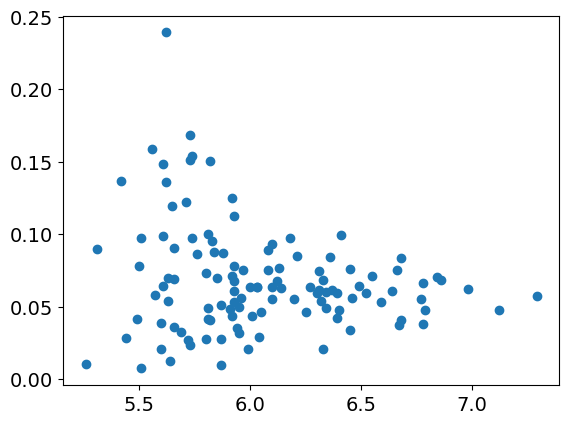

In [69]:
plt.scatter(df_combined['LOG_POP'], df_combined[f'f(g, alpha={alpha})'])
c = random_sample_replc(df_combined, 'LOG_POP', f'f(g, alpha={alpha})', 1)
c[0]

In [70]:
y_fid = 25j
x_fid = 25j
norm_plot = True
tus_thresh = 1
bandwidth = 0.75
scatter = True

trend_collection = []


for q in range(1): 
    for bandwidth in [0.75]:#[i/5 for i in range(1,6)]:
        for pew_thresh in [1]: # Pew Sampling
            for ds_thresh in [3]: # Pew DS threshold (# family members)
                #print(f'tus_count={tus_thresh}, bandwidth={bandwidth}, pew_count={pew_thresh}, ds_thresh={ds_thresh}')
                for a in [17]:#range(len(alphas)):
                    alpha = alphas[a]
                    tus_thresh = s_filters_by_alpha[alpha]
                    df_combined, df_time = get_kde_data(alpha, pew_thresh, ds_thresh, tus_thresh)#, w=False)
                    X, Y, x_array, y_array, positions = get_kde_matrices(df_combined, 'LOG_POP', f'f(g, alpha={alpha})', x_fid, y_fid, 0.01)
                    X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=False, normalize=norm_plot, contrast_trend=False)
                    trend_collection.append(trend)



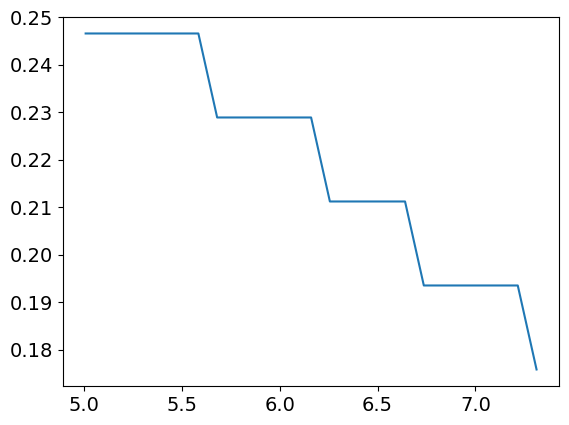

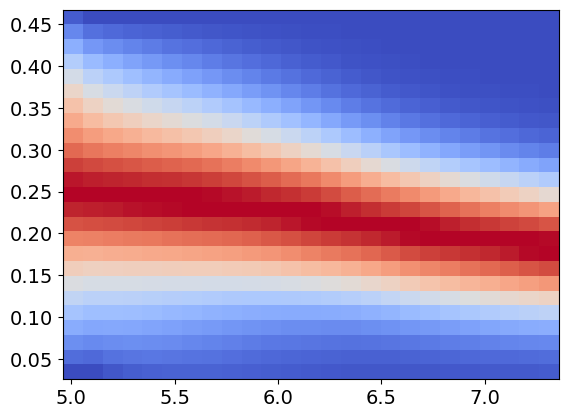

In [71]:
plt.plot(trend[0],trend[1])
plt.show()
plt.pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')

## Boxplot

In [72]:
df_combined

GTCBSA  LOG_POP  f(g, alpha=ALL_TU_H)     phi_D     f/phi  sampling_rate
0     12060     6.77              0.206972  0.621161  0.333203            729
1     47900     6.79              0.159547  0.535040  0.298196            824
2     33100     6.78              0.169949  0.430783  0.394513            678
3     35620     7.29              0.191793  0.564764  0.339599           2033
4     17140     6.34              0.227335  0.779991  0.291459            243
..      ...      ...                   ...       ...       ...            ...
180   28420     5.46              0.279309  0.844070  0.330908             44
181   22900     5.40              0.224644  0.142277  1.578927             19
182   41100     5.22              0.370261  0.205902  1.798240             23
183   12700     5.33              0.170588  0.615869  0.276987             15
184   20100     5.25              0.140443  0.780284  0.179990             22

[185 rows x 6 columns]

In [73]:
df_tus_trunc['TUDIARYDAY'].unique()

array([6., 1., 3., 7., 5., 4., 2.])

In [74]:
def add_boxplot(ax, s, y, colors):
    ax.scatter([s[2]], [y], s=50, c=colors[0], marker='d', zorder=4)
    if len(s[5]) > 0:
        # ax.scatter(s[5], [y for i in range(len(s[5]))], s=30, facecolors=colors[0], edgecolors=colors[0], marker='|', zorder=1, alpha=0.7)
        ax.scatter(s[5], [y for i in range(len(s[5]))], s=16, facecolors='none', edgecolors=colors[0], marker='o', zorder=1, alpha=0.7)
    ax.plot([s[0],s[4]], [y,y], linewidth=1.5, c=colors[1],zorder=2, alpha=0.9)
    ax.plot([s[1],s[3]], [y,y], linewidth=4, c=colors[2],zorder=3, alpha=0.8)
    return ax


def get_boxplot_data(alpha, pew_sampling_threshold, pew_ds_threshold, tus_sampling_threshold, time_string, w=True):
    if time_string == 'all':
        df_tus_f = calc_f(df_tus_trunc, alpha, 60, 6, w=w)
    elif time_string == 'wd':
        df_temp = df_tus_trunc[df_tus_trunc['TUDIARYDAY'].isin([2.0, 3.0, 4.0, 5.0, 6.0])].copy()
        df_tus_f = calc_f(df_temp, alpha, 60, 6, w=w)
    elif time_string == 'we':
        df_temp = df_tus_trunc[df_tus_trunc['TUDIARYDAY'].isin([1.0, 7.0])].copy()
        df_tus_f = calc_f(df_temp, alpha, 60, 6, w=w)
    temp_df = apply_sampling_threshold(df_pew_trunc, 'GTCBSA', pew_sampling_threshold)
    temp_df = apply_ds_threshold(temp_df, 'phi_D', ['GTCBSA','weight'], 'q7_family_members', pew_ds_threshold, pr_bin_cdf, pr_cumu_bins)
    df_pew_phi_d = weighted_agg(temp_df, 'GTCBSA', 'weight', 'phi_D', 'phi_D')
    df_combined = df_tus_cbsa.merge(df_tus_f, on='GTCBSA', how='inner')
    df_combined = df_combined.merge(df_pew_phi_d, on='GTCBSA', how='inner')
    df_combined['f/phi'] = df_combined[f'f(g, alpha={alpha})'] / df_combined['phi_D']

    df_combined['f/phi'] = df_combined['f/phi'].replace([np.inf, -np.inf], np.nan)
    df_combined['f/phi'] = df_combined['f/phi'].replace(np.nan, 0)

    df_combined = df_combined.merge(df_sampling, on='GTCBSA',how='left')
    df_combined = df_combined[df_combined['sampling_rate']>=tus_sampling_threshold]
    df_time = calc_t(df_t, alpha)
    df_time[alpha[:-2]] = df_time[alpha[:-2]]/60
    return df_combined, df_time

alphas_ordered = ['ALL_TU_H', 'SOCIAL_TU_H', 'CARE_TU_H', '1_agg_H', '2_agg_H', '3_agg_H', '4_agg_H', '5_agg_H', 
                    '6_agg_H', '7_agg_H', '8_agg_H', '9_agg_H', '10_agg_H', '11_agg_H', '12_agg_H', '13_agg_H', 
                    '14_agg_H', '15_agg_H', '16_agg_H', '18_agg_H' ]

# alphas_ordered = ['ALL_TU_H', 'SOCIAL_TU_H', 'CARE_TU_H',  '2_agg_H', '3_agg_H', '4_agg_H', '7_agg_H',  '11_agg_H', '12_agg_H', '13_agg_H', 
#                     '14_agg_H',  '18_agg_H' ]

codes_custom = {
'1_agg_H': 'Personal Care', 
'2_agg_H': 'Household', 
'3_agg_H': 'Care, Coresid.', 
'4_agg_H': 'Care, Non-Coresid.', 
'5_agg_H': 'Work', 
'6_agg_H': 'Education', 
'7_agg_H': 'Cons. Purchases', 
'8_agg_H': 'Prof. & Pers. Services',
'9_agg_H': 'Household Services', 
'10_agg_H': 'Government Services & Civics', 
'11_agg_H': 'Eating & Drinking', 
'12_agg_H': 'Social & Leisure', 
'13_agg_H': 'Sports, Exrc & Rec', 
'14_agg_H': 'Religious', 
'15_agg_H': 'Volunteer', 
'16_agg_H': 'Phone calls', 
'18_agg_H': 'Traveling', 
'ALL_TU_H': 'Any', 
'CARE_TU_H': 'Any Care', 
'SOCIAL_TU_H': 'Any Social'
}

alphas_ordered = [
    'ALL_TU_H', 

    'SOCIAL_TU_H', 
    'CARE_TU_H',  
    '12_agg_H', #social
    '11_agg_H', #eat
    '2_agg_H', #household
#    '4_agg_H', #care NH
    '13_agg_H', #sports

    '14_agg_H', #religion
    '3_agg_H', #care HH

#    '18_agg_H', #travel
#    '7_agg_H', #shopping
#    '5_agg_H', #work 
]

alphas_ordered.reverse()

In [75]:
df_collection = {}

time_short_strings = ['we','wd','all']

for tus_thresh in [0]:#[0,25,50,75]:
    for alpha in alphas:
        df_collection[alpha] = {}
        for pew_thresh in [3]: # Pew Sampling
            for ds_thresh in [3]: # Pew DS threshold (# family members)
                for time in time_short_strings:
                    df_combined, df_time = get_boxplot_data(alpha, pew_thresh, ds_thresh, tus_thresh, time)
                    df_collection[alpha][time] = df_combined

[0.09166666666666666, 0.20277777777777778, 0.3138888888888889, 0.425, 0.5361111111111112, 0.6472222222222221, 0.7583333333333333, 0.8694444444444445, 0.9805555555555556]
['Care, Coresid.', 'Religious', 'Sports, Exrc & Rec', 'Household', 'Eating & Drinking', 'Social & Leisure', 'Any Care', 'Any Social', 'Any']


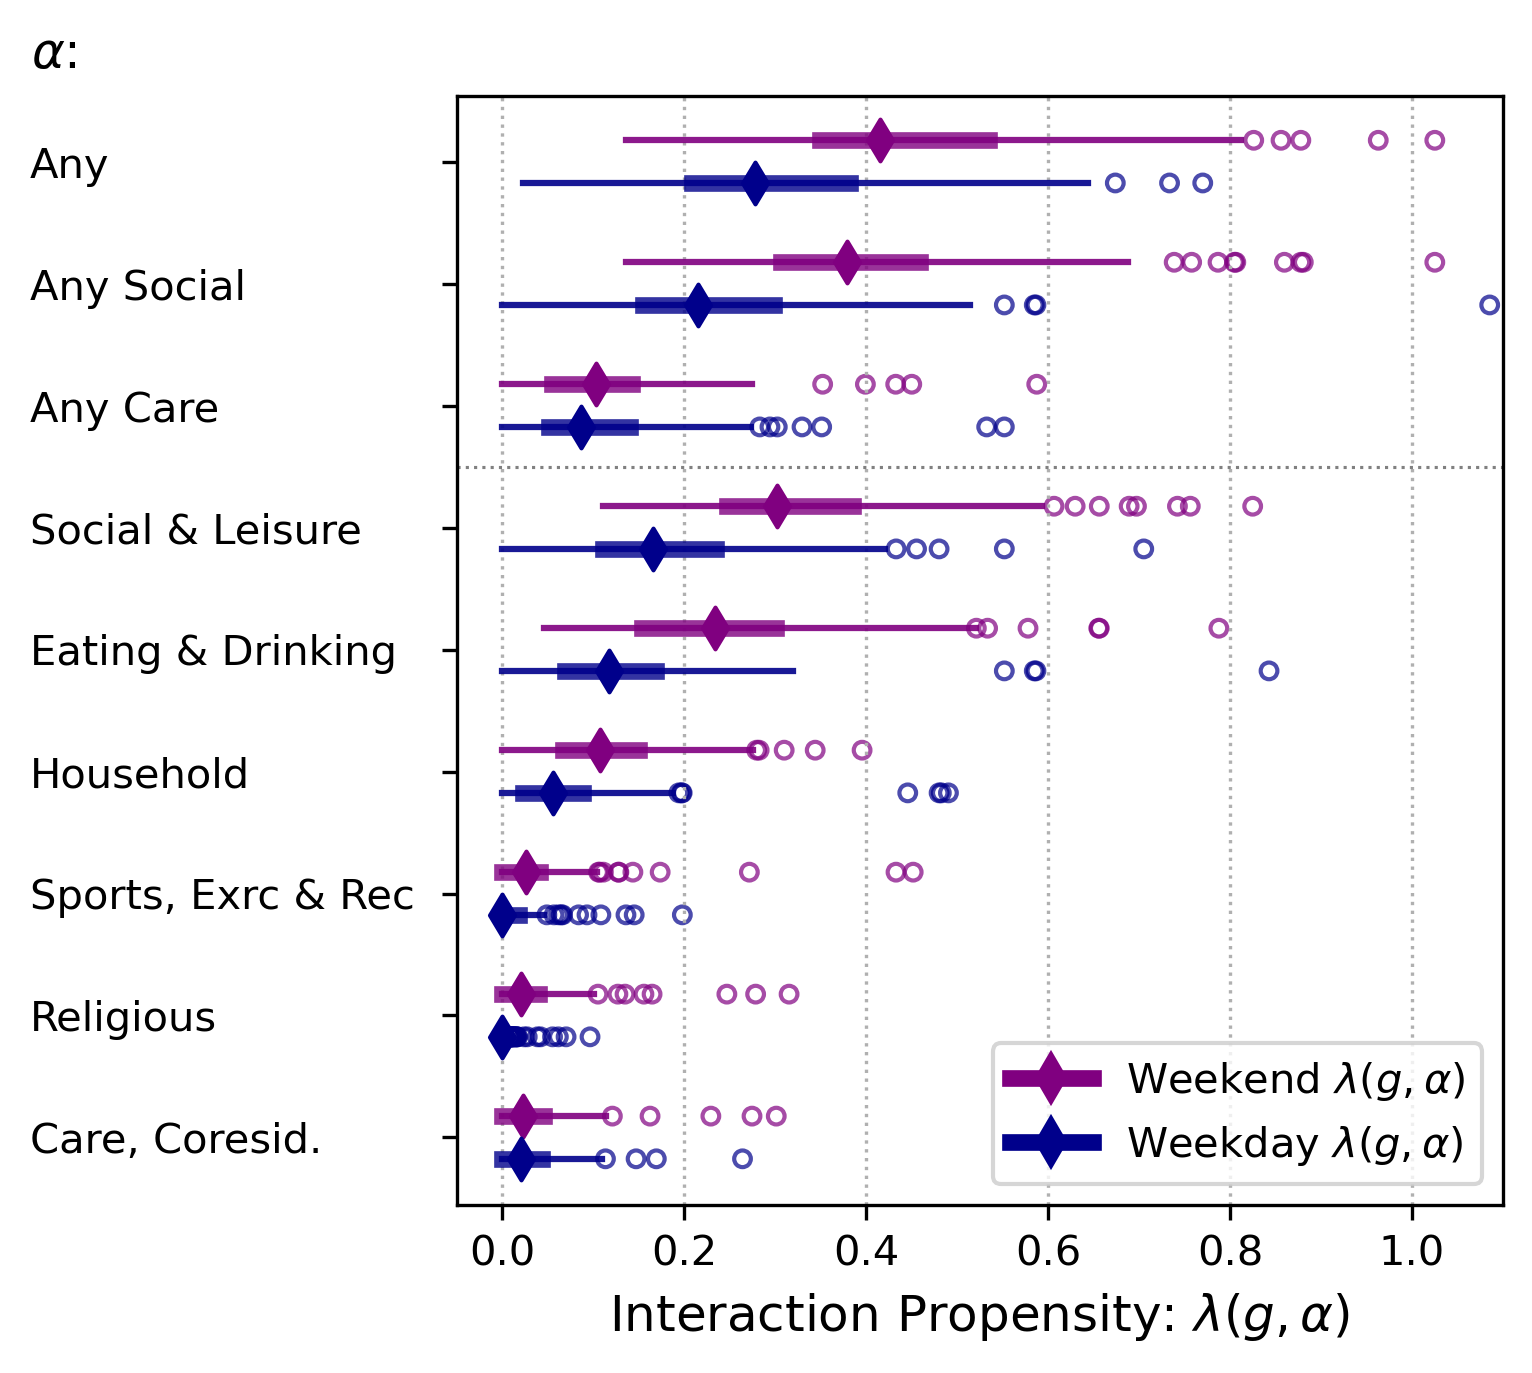

In [144]:
time_strings = ['Weekends','Weekdays','All days']
time_short_strings = ['we','wd']
fig, ax = plt.subplots(1,figsize=(4.5,4.8), dpi=300, facecolor='white')
ys = []
y_strings = []
boxplot_colors = ['purple','darkblue','darkred','darkgreen',]

plt.rcParams['font.size'] = 10

for idx, alpha in enumerate(alphas_ordered):
    y_center = (1/len(alphas_ordered)) * (idx+1)
    for tdx, time in enumerate(time_short_strings): 
        y_offset = y_center + (1/len(alphas_ordered)) * .35 * -1 * tdx
        cs = [boxplot_colors[tdx] for c in range(3)]

        if tdx == 1:
            y_strings.append(codes_custom[alpha])

        df_g = copy.deepcopy(df_collection[alpha][time])
        lambda_var = df_g['f/phi'].tolist()
        vars = [lambda_var]

        for vdx, array in enumerate(vars):
            y = y_offset
            s = boxplot_stats(array)
            ax = add_boxplot(ax, s, y, cs)
            ys.append(y)

ys = [(ys[i]+ys[i+1])/2 for i in range(len(ys)) if i%2==0]
ax.set_xlabel('Interaction Propensity: $\lambda(g,\\alpha)$', fontsize=12)
#ax.set_ylabel('Activity & Day', fontsize=12)
custom_lines = [Line2D([0], [0], color=boxplot_colors[i], lw=4, marker='d', markersize=8,) for i in range(tdx+1)]
legend_labels = [f'{time_strings[i][:-1]} $\lambda(g,\\alpha)$'for i in range(tdx+1)]
#h_line_ys = [(ys[3]+ys[4])/2]#, (ys[6]+ys[7])/2, (ys[10]+ys[11])/2,]
h_line_ys = [(ys[5]+ys[6])/2]
for h in h_line_ys:
   ax.axhline(h, c='grey', linestyle=":", linewidth=0.75)

print(ys)
print(y_strings)

plt.ylim(0.03, 1.04)
plt.xlim(-0.05, 1.1)
plt.yticks(ys, y_strings, fontsize=10, horizontalalignment='left', x=-0.38)
plt.grid(axis='x', linestyle=':')
plt.legend(custom_lines, legend_labels)
plt.figtext(-0.19, 0.90, '$\\alpha$:', fontsize=12)
plt.show()

## 2 Panel Plot for Phi_DS & Lambda

In [78]:
phi_lam = {}
phi_lam_kde = {}

y_fid = 20j
x_fid = 20j

padding = 0.05
bandwidth = 0.8

alpha = 'ALL_TU_H'
tus_thresh = 25
pew_thresh = 3

for ds_thresh in [1,2,3,4,5]: # Pew DS threshold (# family members)
    print(ds_thresh)
    df_combined, df_time = get_kde_data(alpha, pew_thresh, ds_thresh, tus_thresh)
    phi_lam_kde[ds_thresh] = {}

    # phi(g) KDE
    X, Y, x_array, y_array, positions = get_kde_matrices(df_combined, 'LOG_POP', 'phi_D', x_fid, y_fid, padding)
    X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=boundary, normalize=norm_plot, contrast_trend=True)
    phi_lam_kde[ds_thresh]['phi'] = trend

    # lambda(g) KDE
    X, Y, x_array, y_array, positions = get_kde_matrices(df_combined, 'LOG_POP', 'f/phi', x_fid, y_fid, padding, forced_y_max=0.8)
    X, Y, Z, trend = generate_KDE_adj(bandwidth, X, Y, x_array, y_array, positions, boundary=boundary, normalize=norm_plot, contrast_trend=True)
    phi_lam_kde[ds_thresh]['lam'] = trend

1
2
3
4
5


KeyError: 1

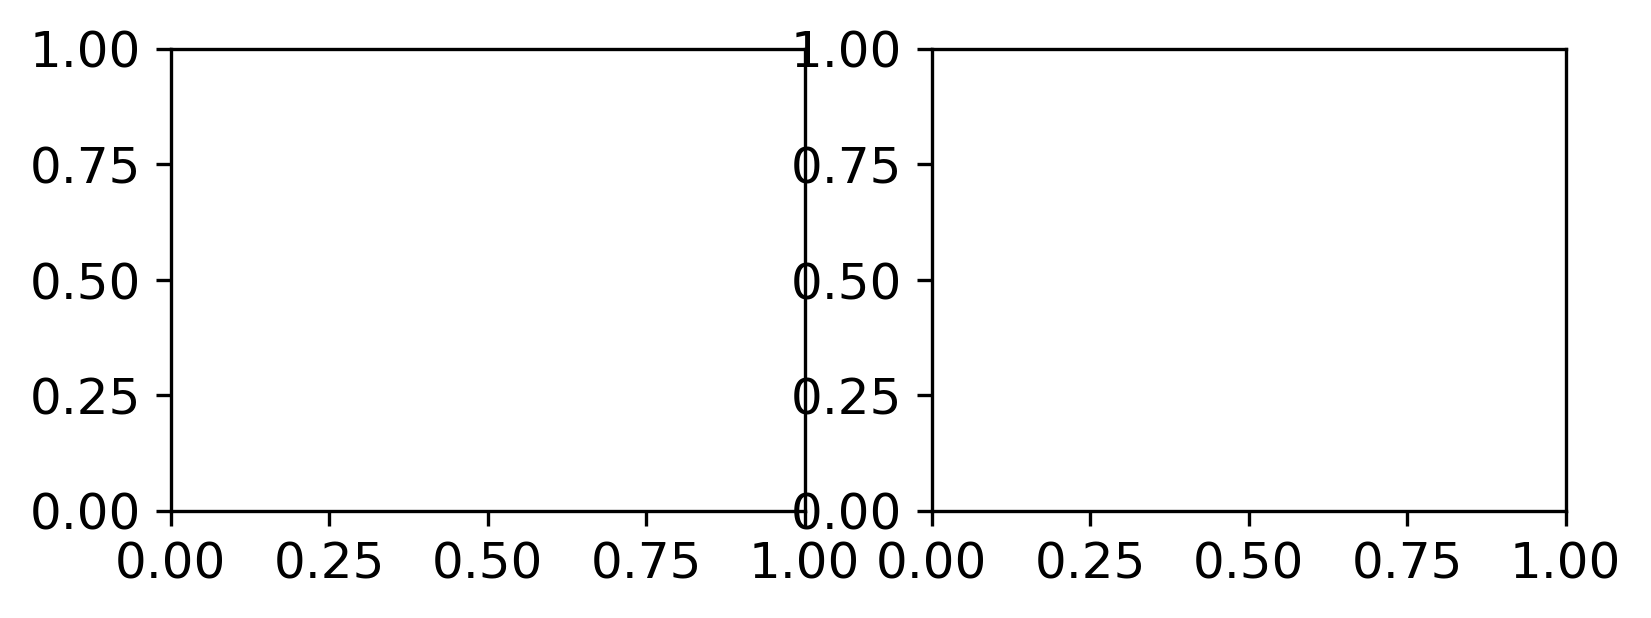

In [79]:
fig, ax = plt.subplots(1,2, facecolor='white', dpi=300, figsize=(6,2))

for nf in range(1,6):
    print(nf, phi_lam[nf].keys())
    phi_x = phi_lam[nf]['phi'][0]
    phi_y = phi_lam[nf]['phi'][1]
    lam_x = phi_lam[nf]['lam'][0]
    lam_y = phi_lam[nf]['lam'][1]